---
# Tipping Module Parameterization A Calibration
---
**Author** : Amaury Laridon

**Date** : 28/10/23

---

Here, we will numerically translate numericaly AGTCCM described in my thesis and which is a generalized application of Monteiro's (2022) method for its calibration part. We first look at the simplest choice of parameterization, i.e. choice "A" for the freshwater flow with a single forcing parameter.

---
## Reminder of the mathematical framework


### AMOC's calibration

We wish to calibrate the following ODE,
$$   \frac{d\Psi}{dt} = (-\Psi^3 + a_1\Psi^2 + b_1\Psi + c_1 + d_1 T_\Psi + e_{12} F_{GIS})\mu_\Psi(\Psi) = f(\Psi, T_\Psi, F_{GIS})
\quad (1)   $$
The mathematical framework described in my thesis has given us the following results for coefficient values,

$$a_1 = \frac{3(\Psi^{-}+\Psi^{+})}{2} \quad (a) $$
$$b_1 =  -3 \Psi^{-}\Psi^+ \quad (b)$$
$$  c_1 + e_{12}F_{GIS}^A  = \frac{T^+_\Psi\Psi^{-^{2}}(\Psi^{-}-3\Psi^+)-T^{-}_\Psi\Psi^{+^{2}}(\Psi^{+}-3\Psi^{-})}{2(T^{-}_\Psi-T^{+}_\Psi)} \quad (c) $$
$$  d_1 = -\frac{(\Psi^{+}-\Psi^{-})^3}{2(T^{+}_\Psi-T^{-}_\Psi)} \quad (d)   $$
$$ c_1 + d_1T_{\Psi}^B = \frac{F_{GIS}^+\Psi^{-^{2}}(\Psi^{-}-3\Psi^+)-F_{GIS}^{-}\Psi^{+^{2}}(\Psi^{+}-3\Psi^{-})}{2(F_{GIS}^{-}-F_{GIS}^{+})} \quad (e) $$
$$  e_{12} =-\frac{(\Psi^{+}-\Psi^{-})^3}{2(F_{GIS}^{+}-F_{GIS}^{-})} \quad (f) $$

By ease of writing we can rewrite equations $(c),(e)$,

$$   c_1 = \frac{T^+_\Psi\Psi^{-^{2}}(\Psi^{-}-3\Psi^+)-T^{-}_\Psi\Psi^{+^{2}}(\Psi^{+}-3\Psi^{-})}{2(T^{-}_\Psi-T^{+}_\Psi)}  - e_{12}F_{GIS}^A  \quad (g)  $$
$$ c_1 = \frac{F_{GIS}^+\Psi^{-^{2}}(\Psi^{-}-3\Psi^+)-F_{GIS}^{-}\Psi^{+^{2}}(\Psi^{+}-3\Psi^{-})}{2(F_{GIS}^{-}-F_{GIS}^{+})} - d_1T_{\Psi}^B \quad (h)  $$

For the experience noted A which represents the sensibility experiment with regard to temperature anomaly and a fixed fresh water flux we have,

$$  \frac{d\Psi}{dt} = (-\Psi^3 + a_1\Psi^2 + b_1\Psi + c_1 + e_{12}^AF_{GIS}^A + d_1^A T_\Psi)\mu_\Psi(\Psi) = f_{ExpA}(\Psi, T_\Psi) \quad (2)  $$

For the experience noted B which represents the sensibility experiment with regard to fresh water flux and a fixed temperature anomaly we have,

$$  \frac{d\Psi}{dt} = (-\Psi^3 + a_1\Psi^2 + b_1\Psi + c_1 + d_1^BT^B + e_{12}^B F_{GIS})\mu_\Psi(\Psi) = f_{ExpB}(\Psi, F_{GIS})  \quad (3)  $$ 

### GIS's calibration 

We wish to calibrate the following ODE,

$$  \frac{dV}{dt} = (-V^3 + a_2V^2 + b_2V + c_2 + d_2  T_V + e_{21} (1-\Psi_V))\mu_V(V, T_V, \Psi_V) = g(V, T_V, \Psi_V) \quad (4)  $$

and the mathematical framework described in my thesis gives the following values,

$$  a_2 = \frac{3(V^{-}+V^{+})}{2} \quad (i) $$
$$  b_2 = -3 V^{-}V^+ \quad (j) $$
$$ c_2 + e_{21}(1-\Psi^C) =  \frac{T^+_VV^{-^{2}}(V^{-}-3V^+)-T^{-}_VV^{+^{2}}(V^{+}-3V^{-})}{2(T^{-}_V-T^{+}_V)} \quad (k) $$
$$ d_2 = -\frac{(V^{+}-V^{-})^3}{2(T^{+}_V-T^{-}_V)} \quad (l) $$ 
$$ c_2 + d_2T^D =  V^+{^3} - a_2V^+{^2} -b_2V^+-e_{21}(1-\Psi_V^+) \quad (m) $$
$$ e_{21} = -\frac{(V^{+}-V^{-})^3}{2(\Psi^{-}_V-\Psi^{+}_V)} \quad (n) $$
$$ c_2 = \frac{T^+_VV^{-^{2}}(V^{-}-3V^+)-T^{-}_VV^{+^{2}}(V^{+}-3V^{-})}{2(T^{-}_V-T^{+}_V)} - e_{21}(1-\Psi^C) \quad (o) $$
$$ c_2 = ( V^+{^3} - a_2V^+{^2} -b_2V^+-e_{21}(1-\Psi_V^+))-d_2T_V^D \quad (p) $$ 

For the sensibility experiment C with regards to the temperature anomaly and a fixed AMOC's intensity we have,

$$ \frac{dV}{dt} = (-V^3 + a_2V^2 + b_2V + c_2 + e_{21}(1-\Psi^C) + d_2  T)\mu_V(V, T, \Psi) = g_{ExpC}(V, T_V, \Psi_V) \quad (5) $$

For the sensibility experiment D with regards to the AMOC's intensity and a fixed temperature anomaly we have,

$$  \frac{dV}{dt} = (-V^3 + a_2V^2 + b_2V + c_2 + d_2 T^D + e_{21} (1-\Psi))\mu_V(V, T, \Psi) = g_{ExpD}(V, T_V, \Psi_V) \quad (6)  $$ 

---
## Numerical implementation of the Calibration Module
---
First, we want to make a numerical implementation of this mathematical framework and test it by giving as input any critical values of the bifurcation coordinates. In other words, we're first going to see whether, given the data we want to reproduce, the algorithm is a good fit before, in a second phase, providing the algorithm with real experimental values as input.


##### Libraries import 

In [113]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import matplotlib.gridspec as gridspec

#%matplotlib nbagg

save_fig_dir = r"C:\Users\AL000111\Documents\Mémoire\Code\LPHYS2299-Master-s-Thesis\AMOC-GIS Tipping Module\Tipping Module Calibration - Param A\Figures"
save_fig_dir_mem = r"C:\Users\AL000111\Documents\Mémoire\Code\LPHYS2299-Master-s-Thesis\AMOC-GIS Tipping Module\Tipping Module Calibration - Param A\Figures\Memoire Fig\\"
# Linux ThinkPad path save_fig_dir = "/home/amaury/Bureau/LPHYS2299 - Master's Thesis/Code/AMOC-GIS Tipping Module/Tipping Module Calibration - Param A/Figures"
# Linux ThinkPad path save_fig_dir_mem ="/home/amaury/Bureau/LPHYS2299 - Master's Thesis/Code/AMOC-GIS Tipping Module/Tipping Module Calibration - Param A/Figures/Memoire Fig/"

### Calibration module 

The critical values of the system variable under study (AMOC or GIS) are generally denoted by $xp, xm$, corresponding to the upper and lower critical values respectively. The critical values of the forcings are noted $op, om$. 

To avoid confusion, I explicitly define a function by coefficients, although the form is the same for many coefficients and I can simply change the arguments of the common function when calling the function and assigning it to the coefficient.

In [114]:
### Definition of the functions computing the coefficient's values. 

## General functions shared by both systems (AMOC and GIS) ## 
def a(xp,xm):
    """Definition of the a_1 coefficient cfr. Eq.(a)"""
    return (3/2)*(xp+xm)
def b(xp,xm):
    """Definition of the b_1 coefficient cfr. Eq.(b)"""
    return -3*xp*xm
def d(xp,xm,op,om):
    """Definition of the d_1 coefficient cfr. Eq.(d)"""
    return -(xp-xm)**3/(2*(op-om))
def xm_today(op,om,xp) :
    """Definition of the constrain that the state of the system is equal to 1, its maximal value when the forcing is equal to zero at pre-industrial times"""
    G = (op+om+2*(op*om)**0.5)/(op-om)
    return (-2+xp*(1+G**(1/3)+G**(-1/3)))/(-1+G**(1/3)+G**(-1/3))

## Functions specific to the AMOC's system ## 

def c_A(xp,xm,op,om):
    return (((op*(xm**2))*(xm-3*xp))-(om*(xp**2)*(xp-(3*xm))))/(2*(om-op)) 
def c_B(xp,xm,op,om):
    return (op*xm**2*(xm-3*xp)-om*xp**2*(xp-3*xm))/(2*(om-op))
def e12(xp,xm,op,om):
    """Definition of the c_12 coefficient cfr. Eq.(f)"""
    return -(xp-xm)**3/(2*(op-om))
def c1_from_A(xp, xm, op1, om1, op2, om2, F_A):
    """Definition of the c_1 coefficient from experience A cfr. Eq.(g)"""
    c_A = (((op1*(xm**2))*(xm-3*xp))-(om1*(xp**2)*(xp-(3*xm))))/(2*(om1-op1))
    e_12 = e12(xp, xm, op2, om2)
    return (c_A - (e_12*F_A))
def c1_from_B(xp, xm, op2, om2, op1, om1, T_B):
    """Definition of the c_1 coefficient from experience B cfr. Eq.(h)"""
    c_B = (op2*xm**2*(xm-3*xp)-om2*xp**2*(xp-3*xm))/(2*(om2-op2))
    d_1 = d(xp, xm, op1, om1)
    return (c_B-(d_1*T_B))

## Functions specific to the GIS's systFem ## 

def e21(xp,xm,op,om):
    """Definition of the e_21 coefficient cfr. Eq.(n)"""
    return -(xp-xm)**3/(2*(om-op))
def c2_from_C(xp,xm,op1,om1,op2,om2,Psi_C):
    """Definition of the c_2 coefficient from experience C cfr. Eq.(o)"""
    c_C = (op1*xm**2*(xm-3*xp)-om1*xp**2*(xp-3*xm))/(2*(om1-op1))
    e_21 = e21(xp,xm,op2,om2)
    return (c_C - (e_21*(1-Psi_C)))
def c2_from_D(xp,xm,op2,om2,op1,om1,T_D):
    """Definition of the c_2 coefficient from experience D cfr. Eq.(p)"""
    e_21 = e21(xp,xm,op2,om2)
    a_2 = a(xp,xm)
    b_2 = b(xp,xm)
    c_D = ((xp**3) - a_2*(xp**2) - b_2*xp - e_21*(1-op2))
    d_2 = d(xp,xm,op1,om1)
    return (c_D-(d_2*T_D))

### Definition of the calibration module ###

## AMOC ## 
def calib_module_AMOC_ParamA(Psip,Psim,Tp,Tm,Fp,Fm,F_A,T_B):
    """Calibration module for the AMOC with the parametrisation A for the fresh water flux. Direct computation based on Eq.(1)"""
    #Psim = xm_today(Tp, Tm, Psip)
    a_1 = a(Psip, Psim)
    b_1 = b(Psip,Psim)
    d_1 = d(Psip,Psim, Tp, Tm)
    e_12 = e12(Psip, Psim, Fp, Fm)
    c1_f_A = c1_from_A(Psip, Psim, Tp, Tm, Fp, Fm, F_A)
    c1_f_B = c1_from_B(Psip, Psim, Fp, Fm, Tp, Tm, T_B)
    return [a_1, b_1, d_1, e_12, c1_f_A, c1_f_B]

def calib_module_AMOC_ParamA_ExpA(Psip,Psim,Tp,Tm):
    """Calibration module for the AMOC with the parametrisation A for the fresh water flux. Computation for the sensibility experiment A based on Eq.(2)"""
    a_1 = a(Psip, Psim)
    b_1 = b(Psip,Psim)
    c1A = c_A(Psip, Psim, Tp, Tm)
    d_1 = d(Psip,Psim, Tp, Tm)
    return [a_1, b_1, c1A, d_1]

def calib_module_AMOC_ParamA_ExpB(Psip,Psim,Fp,Fm):
    """Calibration module for the AMOC with the parametrisation A for the fresh water flux. Computation for the sensibility experiment B based on Eq.(3)"""
    a_1 = a(Psip, Psim)
    b_1 = b(Psip,Psim)
    c1B = c_B(Psip, Psim, Fp, Fm)
    e_12 = e12(Psip, Psim, Fp, Fm)
    return [a_1, b_1, c1B, e_12]

## GIS ## 
def calib_module_GIS(Vp, Vm, Tp, Tm, Psip, Psim, Psi_C, T_D):
    """Calibration module for the GIS"""
    Vm = xm_today(Tp, Tm, Vp)
    a_2 = a(Vp, Vm)
    b_2 = b(Vp, Vm)
    d_2 = d(Vp, Vm, Tp, Tm)
    e_21 = e21(Vp, Vm, Psip, Psim)
    c2_f_C = c2_from_C(Vp, Vm, Tp, Tm, Psip, Psim, Psi_C)
    c2_f_D = c2_from_D(Vp, Vm, Psip, Psim, Tp, Tm, T_D)
    return [a_2, b_2, d_2, e_21, c2_f_C, c2_f_D]


### Data and coefficients calibration based on it

In [115]:
##### Sensibility Experiment parameters #####

### AMOC ###print("c = {:.3f}".format(c_AMOC))
F_A = 0.25 # Constant value of the fresh water flux for the sensibility experiment A [Sv] 
T_B = 3 # Constant value of the temperature for the sensibility experiment B [°C]
T_max_ExpA = 10 # Maximum value of the temperature forcing for the sensibility experiment A [°C]
T_min_ExpA = 0 # Minimal value of the temperature forcing for the sensibility experiment A [°C]
dT_AMOC = 0.01 # Infinitesimal value for the temperature forcing in the sensibility experiment A [°C] 
F_max = 1 # Maximum value of the fresh water flux forcing for the sensibility experiment B [Sv]
F_min = 0 # Minimum value of the fresh water flux forcing for the sensibility experiment B [Sv]
dF = 0.0005 # Infinitesimal value for the fresh water flux forcing in the sensibility experiment B [Sv] 
crit_time_scale_sep_AMOC = 0.3 # Intensity of the AMOC at which there is a seperation of the dynamic's time scale [Adim]

### GIS ###
Psi_C = 0.3 # Constant value of the AMOC's intensity for the sensibility experiment C [Adim]
T_D = 1.5 # Constant value of the temperature for the sensibility experiment D [°C]
T_max_ExpC = 10 # Maximum value of the temperature forcing for the sensibility experiment C [°C]
T_min_ExpC = 0 # Minimal value of the temperature forcing for the sensibility experiment C [°C]
dT_GIS = 0.01 # Infinitesimal value for the temperature forcing in the sensibility experiment C [°C] 
Psi_max_ExpD = 1 # Maximal value of the AMOC's intensity for the sensibility experiment D [Adim]
Psi_min_ExpD = 0 # Minimal value of the AMOC's intensity for the sensibility experiment D [Adim]
dPsi = 0.01 # Infinitesimal value for the AMOC forcing in the sensitivity experiment D [Adim]

##### Critical Bifurcation Data #####

alpha_GIS = 0.2 # constant to link the variation of the GIS volume in time with a freshwater flux 

### Data from Victor Couplet (2023) ###

couplet_values = True 
couplet_normal_case = True 
couplet_worst_case = False

if couplet_values:
    if couplet_normal_case:
        ## Couplet SURFER v3.0 "normal case" values for AMOC ##  
        Psip_AMOC = 0.77 # Higher critical value of the AMOC intensity 
        Tp_AMOC = 4 # Higher critical temperature forcing value for the AMOC 
        Tm_AMOC = 0 # Lower critical temperature forcing value for the AMOC 
        Fp_AMOC = 0.5 # Higher critical fresh water forcing value for the AMOC (Non defined in Couplet (2023))
        Fm_AMOC = 0.05 # Lower critical fresh water forcing value for the AMOC (Non defined in Couplet (2023))
        Psim_AMOC = xm_today(Tp_AMOC,Tm_AMOC,Psip_AMOC) # Lower critical value of the AMOC intensity
        taup_AMOC = 50 # Timescale associated to the AMOC when it is on its ON state
        taum_AMOC = 50 # Timescale associated to the AMOC when it is on its OFF state
        ### Couplet SURFER v3.0 "normal case" values for GIS ###
        Vp_GIS = 0.77 # Higher critical value of the GIS volume
        Tp_GIS = 1.52 # Higher critical temperature forcing value for the GIS
        Tm_GIS = 0.3 # Lower critical temperature forcing value for the GIS
        Psip_GIS = 0.7 # Higher critical AMOC's intensity value for the GIS (Non defined in Couplet (2023))
        Psim_GIS = 0.1 # Lower critical AMOC's intensity value for the GIS (Non defined in Couplet (2023))
        Vm_GIS = xm_today(Tp_GIS, Tm_GIS, Vp_GIS) # Lower critical value of the GIS volume
        taup_GIS = 2000 # Timescale associated to the GIS when it is on its ON state
        taum_GIS = 2000 # Timescale associated to the GIS when it is on its OFF state
    if couplet_worst_case:
        ## Couplet SURFER v3.0 "worst case" values for AMOC ##  
        Psip_AMOC = 0.77 
        Tp_AMOC = 1.4 
        Tm_AMOC = 0 
        Fp_AMOC = 0.5 # Non defined in Couplet (2023)
        Fm_AMOC = 0.05 # Non defined in Couplet (2023)
        Psim_AMOC = xm_today(Tp_AMOC,Tm_AMOC,Psip_AMOC) 
        taup_AMOC = 15 
        taum_AMOC = 15
        ### Couplet SURFER v3.0 "worst case" values for GIS ###
        Vp_GIS = 0.77 
        Tp_GIS = 0.8
        Tm_GIS = 0.3
        Psip_GIS = 0.7 # Non defined in Couplet (2023)
        Psim_GIS = 0.1 # Non defined in Couplet (2023)
        Vm_GIS = xm_today(Tp_GIS, Tm_GIS, Vp_GIS) 
        taup_GIS = 1000 
        taum_GIS = 1000 

AMOC_crit_params = [Psip_AMOC, Psim_AMOC, Tp_AMOC, Tm_AMOC, Fp_AMOC, Fm_AMOC, taup_AMOC, taum_AMOC] # List containing all the AMOC's critical parameters
GIS_crit_params = [Vp_GIS, Vm_GIS, Tp_GIS, Tm_GIS, Psip_GIS, Psim_GIS, taup_GIS, taum_GIS] # List containing all the GIS's critical parameters

##### Computation of the calibrated coefficient in the tipping point cascade module with respect to the critical data given #####

## Computation and assignation ## 

AMOC_Module_calib_coeff = calib_module_AMOC_ParamA(AMOC_crit_params[0], AMOC_crit_params[1], AMOC_crit_params[2], AMOC_crit_params[3], AMOC_crit_params[4], AMOC_crit_params[5], F_A, T_B) 
a_AMOC = AMOC_Module_calib_coeff[0]
b_AMOC = AMOC_Module_calib_coeff[1]
c_AMOC = AMOC_Module_calib_coeff[4]
d_AMOC = AMOC_Module_calib_coeff[2]
e_AMOC = AMOC_Module_calib_coeff[3]

GIS_Module_calib_coeff = calib_module_GIS(GIS_crit_params[0], GIS_crit_params[1], GIS_crit_params[2], GIS_crit_params[3], GIS_crit_params[4], GIS_crit_params[5], Psi_C, T_D) 
a_GIS = GIS_Module_calib_coeff[0]
b_GIS = GIS_Module_calib_coeff[1]
c_GIS = GIS_Module_calib_coeff[4]
d_GIS = GIS_Module_calib_coeff[2]
e_GIS = GIS_Module_calib_coeff[3]

## Output ##
print("-----------------------------------------------------------")
print("Calibrated coefficient for the tipping cascade module")
print("-----------------------------------------------------------")
print("----------------")
print("AMOC")
print("----------------")
print("a = {:.3f}".format(a_AMOC))
print("b = {:.3f}".format(b_AMOC))
print("c = {:.3f}".format(c_AMOC))
print("d = {:.3f}".format(d_AMOC))
print("e = {:.3f}".format(e_AMOC))
print("c value from experience B = {:.3f}".format(AMOC_Module_calib_coeff[5]))
print("----------------")
print("GIS")
print("----------------")
print("a = {:.3f}".format(a_GIS))
print("b = {:.3f}".format(b_GIS))
print("c = {:.3f}".format(c_GIS))
print("d = {:.3f}".format(d_GIS))
print("e = {:.3f}".format(e_GIS))
print("c value from experience D = {:.3f}".format(GIS_Module_calib_coeff[5]))
print("-----------------------------------------------------------")

-----------------------------------------------------------
Calibrated coefficient for the tipping cascade module
-----------------------------------------------------------
----------------
AMOC
----------------
a = 1.620
b = -0.716
c = 0.123
d = -0.012
e = -0.108
c value from experience B = 0.138
----------------
GIS
----------------
a = 1.684
b = -0.815
c = 0.088
d = -0.030
e = 0.061
c value from experience D = 0.112
-----------------------------------------------------------


---
## Definition of the ODE model and Solving
---
### Definition of the ODE model version used for phase portrait plot

In [116]:
### Calibrated Sensitivity Experiment's coefficients ###

AMOC_Module_calib_coeff_ExpA = calib_module_AMOC_ParamA_ExpA(AMOC_crit_params[0], AMOC_crit_params[1], AMOC_crit_params[2], AMOC_crit_params[3])
AMOC_Module_calib_coeff_ExpB = calib_module_AMOC_ParamA_ExpB(AMOC_crit_params[0], AMOC_crit_params[1], AMOC_crit_params[4], AMOC_crit_params[5])

##### Definition of the ODE's #####

### AMOC ###

def dPsi_dt(Psi, T_forcing, F_forcing, model_parameters):
    """Definition of the Eq.(1)"""

    AMOC_Module_calib_coeff = calib_module_AMOC_ParamA(model_parameters[0], model_parameters[1], model_parameters[2], model_parameters[3], model_parameters[4], model_parameters[5], F_forcing, T_forcing)

    a_AMOC = AMOC_Module_calib_coeff[0]
    b_AMOC = AMOC_Module_calib_coeff[1]
    c_AMOC = AMOC_Module_calib_coeff[4]
    d_AMOC = AMOC_Module_calib_coeff[2]
    e_AMOC = AMOC_Module_calib_coeff[3]
    
    def mu_psi(Psi):
        if crit_time_scale_sep_AMOC<Psi:
            return 1/model_parameters[6]
        else:
            return 1/model_parameters[7]

    return mu_psi(Psi)*(-Psi**3 + a_AMOC*Psi**2 + b_AMOC*Psi + c_AMOC + d_AMOC*T_forcing + e_AMOC*F_forcing)

def dPsi_dt_ExpA(Psi, T_forcing, model_parameters):
    """Definition of the Eq.(2), sensitivity experiment A of temperature with fixed fresh water forcing"""
    Psip, Psim, Tp, Tm, Fp, Fm, taup, taum = model_parameters

    a_AMOC = AMOC_Module_calib_coeff_ExpA[0]
    b_AMOC = AMOC_Module_calib_coeff_ExpA[1]
    c_A_AMOC = AMOC_Module_calib_coeff_ExpA[2]
    d_AMOC = AMOC_Module_calib_coeff_ExpA[3]

    def mu_psi(Psi):
        if 0.3<Psi:
            return 1/model_parameters[6]
        else:
            return 1/model_parameters[7]

    return mu_psi(Psi)*(-Psi**3 + a_AMOC*Psi**2 + b_AMOC*Psi + c_A_AMOC + d_AMOC*T_forcing)

def dPsi_dt_ExpB(Psi, F_forcing, model_parameters):
    """Definition of the Eq.(3), sensitivity experiment B of fresh water forcing with fixed temperature forcing"""
    Psip, Psim, Tp, Tm, Fp, Fm, taup, taum = model_parameters

    a_AMOC = AMOC_Module_calib_coeff_ExpB[0]
    b_AMOC = AMOC_Module_calib_coeff_ExpB[1]
    c_B_AMOC = AMOC_Module_calib_coeff_ExpB[2]
    e_AMOC = AMOC_Module_calib_coeff_ExpB[3]    

    def mu_psi(Psi):
        if 0.3<Psi:
            return 1/model_parameters[6]
        else:
            return 1/model_parameters[7]

    return mu_psi(Psi)*(-Psi**3 + a_AMOC*Psi**2 + b_AMOC*Psi + c_B_AMOC + e_AMOC*F_forcing)

### GIS ### 

def dV_dt(V, T_forcing, Psi_forcing, model_parameters):
    """Definition of the Eq.(4)"""

    GIS_Module_calib_coeff = calib_module_GIS(model_parameters[0], model_parameters[1], model_parameters[2], model_parameters[3], model_parameters[4], model_parameters[5], Psi_forcing, T_forcing)

    a_GIS = GIS_Module_calib_coeff[0]
    b_GIS = GIS_Module_calib_coeff[1]
    c_GIS = GIS_Module_calib_coeff[4]
    d_GIS = GIS_Module_calib_coeff[2]
    e_GIS = GIS_Module_calib_coeff[3]

    def H_V(V, T_forcing, Psi_forcing):
        return (-V**3+a_GIS*V**2+b_GIS*V+c_GIS+d_GIS*T_forcing+e_GIS*(1-Psi_forcing))

    def mu_V(V, T_forcing, Psi_forcing):
        h_V = H_V(V, T_forcing, Psi_forcing)
        if h_V>0:
            return 1/model_parameters[6]
        else: 
            if V < 10**(-4):
                return 0.0
            else:
                return 1/model_parameters[7]
    
    return mu_V(V, T_forcing, Psi_forcing)*(-V**3+a_GIS*V**2+b_GIS*V+c_GIS+d_GIS*T_forcing+e_GIS*(1-Psi_forcing))


#### Function $f$ of the AMOC dynamics

In [117]:
def f(t, psi, model_parameters):
    F = amoc_forcing_freshwater(t)
    T = amoc_forcing_temperature(t)
    dpsi = np.zeros(1)

    def mu_psi(psi):
        """Definition of the time scale for the AMOC based on the regime consider"""
        if crit_time_scale_sep_AMOC < psi:
            return 1 / model_parameters[6]
        else:
            return 1 / model_parameters[7]

    dpsi[0] = mu_psi(psi[0])(-psi[0]**3+a_AMOC*psi[0]**2+b_AMOC*psi[0]+c_AMOC+d_AMOC*T+e_AMOC*F)

    return dpsi

#### Function $g$ of the GIS dynamics

In [118]:
def g(t, v, model_parameters):
    T = gis_forcing_temperature(t)
    Psi = gis_forcing_psi(t)
    dv = np.zeros(1)

    def H_V(v):
        return (-v**3+a_GIS*v**2+b_GIS*v+c_GIS+d_GIS*T[t]+e_GIS*(1-Psi[t]))

    def mu_V(v):
        h_V = H_V(v)
        if h_V>0:
            return 1/model_parameters[6]
        else: 
            if v < 10**(-4):
                return 0.0
            else:
                return 1/model_parameters[7]

    dv[0] = mu_V(v[0])(-v[0]**3+a_GIS*v[0]**2+b_GIS*v[0]+c_GIS+d_GIS*T+e_GIS*(1-F))

    return dv

#### Cascade Module Dynamics - Function of the AMOC and GIS dynamics

In [119]:
def cascade_module_dynamics(t, y):
    """Function that encodes the coupled dynamics of the AMOC and GIS based on our simplified model with calibrated coefficients. Returns the vector with the derivatives that will be integrated in time"""
    psi = y[0]
    v = y[1]
    dy = np.zeros(2) # definition of the vector that will contains the derivatives = [dpsi,dv]

    ### Definition of the forcings ### 
    T_forcing = forcing_temperature(t)
    AMOC_F_forcing = amoc_forcing_freshwater(dy[1])

    ### Time scales computations ###

    ## AMOC ## 
    def mu_psi(y):
        """Definition of the time scale for the AMOC based on the regime consider"""
        if crit_time_scale_sep_AMOC < psi:
            return 1/taup_AMOC
        else:
            return 1/taum_AMOC

    ## GIS ## 
    def H_V(y):
        return (-y[1]**3+a_GIS*y[1]**2+b_GIS*y[1]+c_GIS+d_GIS*T[t]+e_GIS*(1-Psi[t]))

    def mu_V(y):
        h_V = H_V(v)
        if h_V>0:
            return 1/taup_GIS
        else: 
            if v < 10**(-4):
                return 0.0
            else:
                return 1/taum_GIS

    ### Computations of the derivatives encoding the dynamics ###

    dy[0] = mu_psi(y[0])(-y[0]**3+a_AMOC*y[0]**2+b_AMOC*y[0]+c_AMOC+d_AMOC*T_forcing+e_AMOC*AMOC_F_forcing)
    dy[1] = mu_V(y[1])(-y[1]**3+a_GIS*y[1]**2+b_GIS*y[1]+c_GIS+d_GIS*T_forcing+e_GIS*(1-y[0]))

    return dy

### Computation of the ODE model

Required Libraries 

In [120]:
import numpy as np

from scipy.integrate import solve_ivp, odeint
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

Simulation Parameters

In [121]:
t0 = 0  # year for the start of the simulation
tend = 40000  # year for the end of the simulation
dt = 1  # iteration time step in years
y0 = [1,1] # initial value for psi(t=0) and v_gis(t=0) = [psi(t=0), v_gis(t=0)] 

Definition of the forcings parametrisation

In [122]:
### Shared forcing ###
## Temperature Forcing ## 
T_forcing_max = 4
forcing_temperature = interpolate.interp1d([t0,(t0+tend)/2,tend],[0,T_forcing_max,0],bounds_error= False, fill_value=0)

### AMOC Forcing ###
def amoc_forcing_freshwater(dv):
    F_GIS = alpha_GIS*dv 
    return F_GIS

Solver

In [123]:
n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n) # integrators parameters 

#sol=solve_ivp(cascade_module_dynamics, [t0,tend], y0,method= 'LSODA',t_eval=teval, max_step = 10000)

---
## Calibration Validation - Version 1.0
---

The first test we can make in order to test the validity of our calibration's algorithm is to calibrate our simplified model Eq.(1) on itself. We will arbitrarily fixed the values of the coefficient then act as we didn't know them anymore but only by finding the coordinates of the critical bifurcations points and then feeding them into our alogirthm compute the coefficent. Since the algorithm is the same for the AMOC and GIS calibration we will only test it here for the AMOC.

### For Sensibility Experiment A

First I will test this on the sensibility experiment A that reduces to Eq.(2) then we will try on the Eq.(1). In other words I will : 

1. Arbitrary fix the values of $a_1,b_1,c_1^A,d_1$ to $a_1^*,b_1^*,c_1^{A*},d_1^*$.
2. Compute the critical values coordinates $(\Psi^+, \Psi^-, T_\Psi^+, T_\Psi^-)$ associated to the arbirary model
3. Insert these last critical values into the algorithm 
4. Compare the calibrated simplified model obtain with the initial model with arbitrary fixed coefficient values. 

For the Sensitivity Experiment A I also have to fixed an arbitrary value for $F_{GIS}=F_{GIS}^*$

**Step 1 - Fixing coefficients values** 

In [124]:
### Arbitrary fixed values for the coefficients ###
a_1_star = 1.5
b_1_star = -0.5
c_1A_star = 0.3
d_1_star = -0.1
F_A_star = 0.1

**Step 2 - Critical values coordinates computation**

At equilibrium in our case of the sensibility experiment A we can express the value of the temperature anomaly forcing with respect to the equilibrium value of $\psi$. This is the equation Eq.(7) and is better explain below where we compute the bifurcation diagram. Here we express it for the specific case of the sensibility experiment A.

$$ T = (\psi^3-a_1\psi^2-b_1\psi-c_1^A)\frac{1}{d_1} = T(\psi) \quad (7') $$ 

We will compute and plot the $(\psi, T(\psi))$ graph. The critical values $(\Psi^+, T^+), (\Psi^-, T^-)$ will be the roots of the derivative of this function. We compute,

$$ \frac{dT(\psi)}{d\psi}  = \frac{1}{d_1}(3 \psi^2-2a_1 \psi-b_1) \quad (7.1)$$

We find that the roots are,

$$ \psi^\pm = \frac{2a_1 \pm \sqrt{4a_1^2+12b_1}}{6} \quad (7.2)$$

and to find $T^\pm$ we simply compute $T(\psi^\pm) = T^\pm$.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


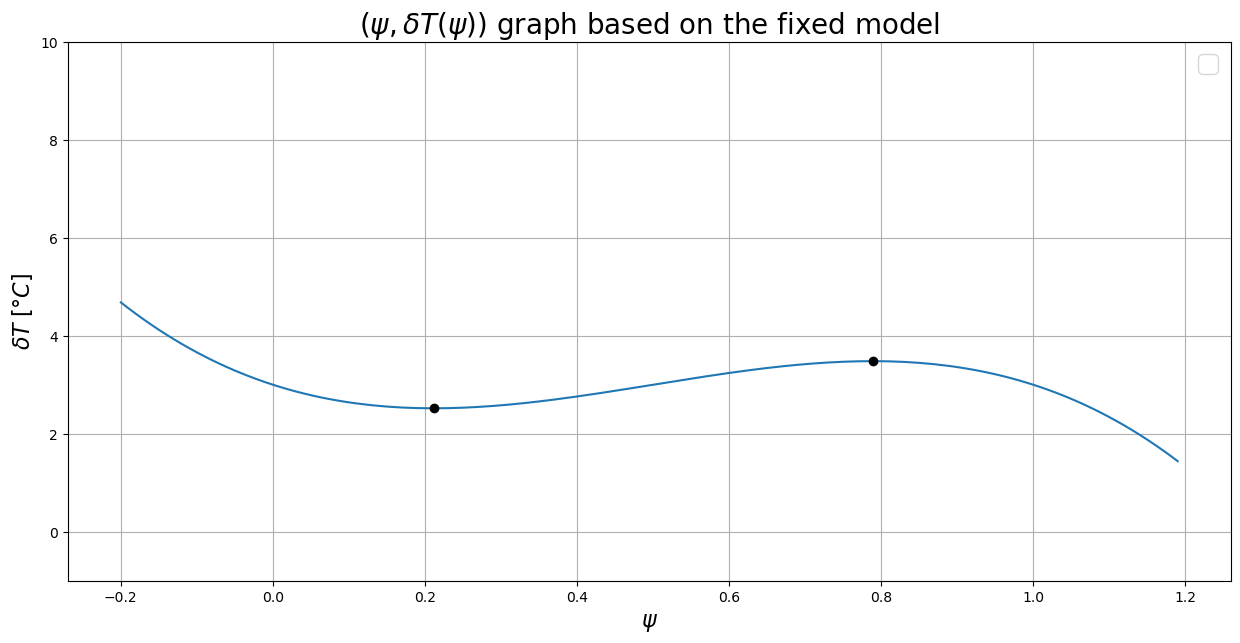

-----------------------------------------------------------
Critical values from the arbitrary fixed coefficient model
-----------------------------------------------------------
Psip_star = 0.789
Psim_star = 0.211
Tp_star = 3.481
Tm_star = 2.519
-----------------------------------------------------------


In [125]:
### Computation of T(psi) ###

# Definition of the function folowing Eq.(7')
def T_funct_psi_star(psi):
  return ((psi**3 - a_1_star*(psi**2) - b_1_star*psi - c_1A_star)*(1/d_1_star))

# Computation of the functions # 
dx=0.01
psi_range = np.arange(-0.2,1.2,dx)
T_fct_psi_star = T_funct_psi_star(psi_range)

### Computation of the roots ###

# Equation (7.1)
def psi_plus_roots(a,b):
  return ((2*a + np.sqrt(4*(a**2)+12*b))/(6))

# Equation (7.2)
def psi_min_roots(a,b) :
  return ((2*a - np.sqrt(4*(a**2) + 12*b))/(6))

Psip_star = psi_plus_roots(a_1_star, b_1_star)
Psim_star = psi_min_roots(a_1_star, b_1_star)
Tp_star = T_funct_psi_star(Psip_star)
Tm_star = T_funct_psi_star(Psim_star)

### Plot of (psi,T(psi)) ###

fig, ax = plt.subplots(1,1,figsize=(15,7))

plt.plot(psi_range, T_fct_psi_star)
plt.plot(Psim_star, Tm_star, "ko")
plt.plot(Psip_star, Tp_star, "ko")
ax.set_xlabel(r"$\psi$", fontsize=16)
ax.set_ylabel(r"$\delta T\;[°C]$", fontsize=16)
ax.set_ybound([-1,10])
plt.title(r"$(\psi, \delta T(\psi))$ graph based on the fixed model", fontsize = 20)
plt.legend(fontsize=18)
plt.grid()

plt.show()

### Output of the critical values from the arbitrary fixed model ###
print("-----------------------------------------------------------")
print("Critical values from the arbitrary fixed coefficient model")
print("-----------------------------------------------------------")
print("Psip_star = {:.3f}".format(Psip_star))
print("Psim_star = {:.3f}".format(Psim_star))
print("Tp_star = {:.3f}".format(Tp_star))
print("Tm_star = {:.3f}".format(Tm_star))
print("-----------------------------------------------------------")

**Step 3 - Computation of the calibrated coefficient using the algorithm**

Now I will feed the algorithm with those critical values and hopefully I should obtain as calibrated coefficients the same as the one I have arbitrarily fixed at the beginning.


In [126]:
## Computation and asignation of the coefficient values from the calibrated algorithm ##

Verif_Module_Calib_coeff_ExpA = calib_module_AMOC_ParamA_ExpA(Psip_star, Psim_star, Tp_star, Tm_star)

a_mod = Verif_Module_Calib_coeff_ExpA[0]
b_mod = Verif_Module_Calib_coeff_ExpA[1]
cA_mod = Verif_Module_Calib_coeff_ExpA[2]
d_mod = Verif_Module_Calib_coeff_ExpA[3]


**Step 4 - Comparaison between original values and calibrated values**

In [127]:
## Output ##
print("-----------------------------------------------------------")
print("Original arbitrarily fixed coefficient values")
print("-----------------------------------------------------------")
print("a_star = {:.3f}".format(a_1_star))
print("b_star = {:.3f}".format(b_1_star))
print("cA_star = {:.3f}".format(c_1A_star))
print("d_star = {:.3f}".format(d_1_star))
print("-----------------------------------------------------------")
print("Calibrated coefficient values")
print("-----------------------------------------------------------")
print("a_mod = {:.3f}".format(a_mod))
print("b_mod = {:.3f}".format(b_mod))
print("cA_mod = {:.3f}".format(cA_mod))
print("d_mod = {:.3f}".format(d_mod))
print("-----------------------------------------------------------")

-----------------------------------------------------------
Original arbitrarily fixed coefficient values
-----------------------------------------------------------
a_star = 1.500
b_star = -0.500
cA_star = 0.300
d_star = -0.100
-----------------------------------------------------------
Calibrated coefficient values
-----------------------------------------------------------
a_mod = 1.500
b_mod = -0.500
cA_mod = 0.300
d_mod = -0.100
-----------------------------------------------------------


### For Sensibility Experiment B

With sensibility experiment A we managed to calibrate $a_1, b_1, d_1$ to their initial arbitrary values $a_1^*, b_1^*, d_1^*$. We also managed to calibrate $c_1^{A}$ to $c_1^{A*}$.

In other words from the general equation Eq.(1) we already have 3 of the 5 coefficients. We still have to find $e_{12}$ and $c_1$.

Now I would like to calibrate my model with regards to sensibility experiment B using the same values founded for $a_1,b_1,d_1$. We have made the assumption that $\Psi^+_{ExpA} = \Psi^+_{ExpB} \equiv \Psi^+$ and $\Psi^-_{ExpA} = \Psi^-_{ExpB} \equiv \Psi^-$, see *[[Note de Travail - Cadre Mathématique Module Tipping Cascade et Calibration Coefficients de couplage]]* for justification.

**Step 1 - Fixing coefficients values**

In [128]:
### Arbitrary fixed values that remains for the Sensitivity Experiment B ### 

c_1B_star = 0.5
e_12_star = -0.1
T_B_star = 2.5

**Step 2 - Critical values coordinates computation**

Based on Eq.(8) we find,

$$ F_{GIS} = (\psi^3-a_1\psi^2-b_1\psi-c_1^B)\frac{1}{e_{12}} \quad (8') $$

Since $\Psi^+_{ExpA} = \Psi^+_{ExpB} \equiv \Psi^+$ and $\Psi^-_{ExpA} = \Psi^-_{ExpB} \equiv \Psi^-$ we don't have the find again the roots corresponding to the critical regimes bifurcation values for $\Psi$. We now have to find the values $F_{GIS}^\pm$ which are given by inserting the previously computed $\Psi^{\pm}$ into Eq.(8')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


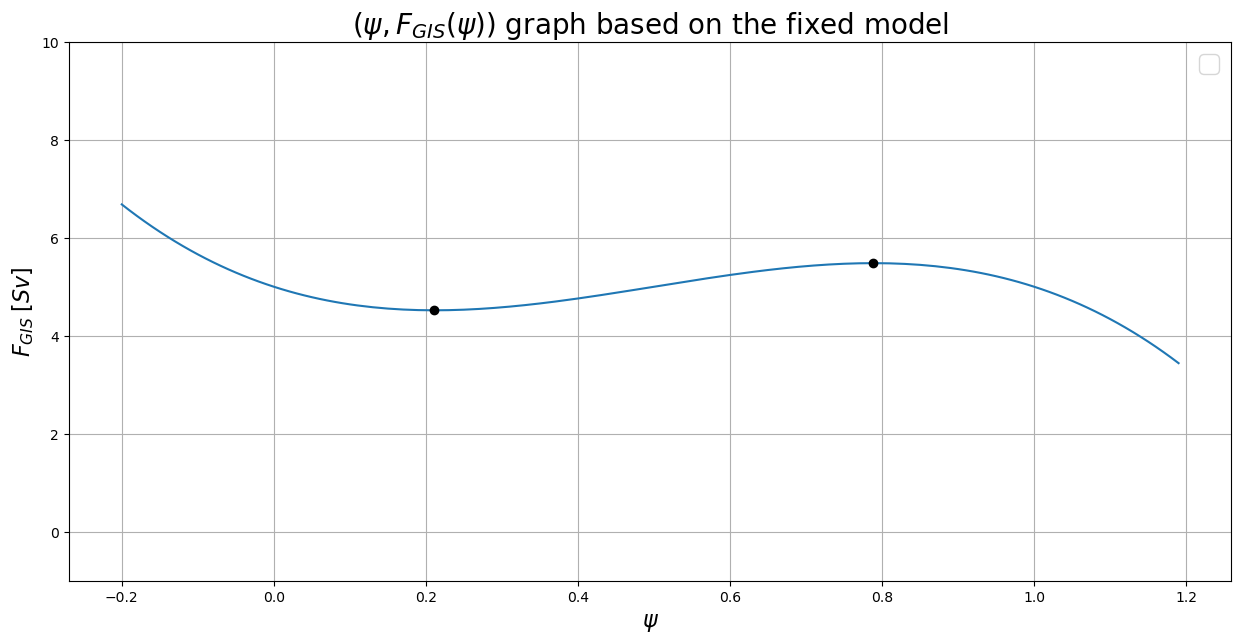

-----------------------------------------------------------
Critical values from the arbitrary fixed coefficient model
-----------------------------------------------------------
Psip_star = 0.789
Psim_star = 0.211
Fp_star = 5.481
Fm_star = 4.519
-----------------------------------------------------------


In [129]:
# Definition of the function folowing Eq.(8')
def F_funct_psi_star(psi):
  return ((psi**3 - a_1_star*(psi**2) - b_1_star*psi - c_1B_star)*(1/e_12_star))

# Computation of the fresh water flux critical values associated # 

Fp_star = F_funct_psi_star(Psip_star)
Fm_star = F_funct_psi_star(Psim_star)

### Plot of (psi,F(psi)) ###

# Computation of the functions # 
dx=0.01
psi_range = np.arange(-0.2,1.2,dx)
F_fct_psi_star = F_funct_psi_star(psi_range)

fig, ax = plt.subplots(1,1,figsize=(15,7))

plt.plot(psi_range, F_fct_psi_star)
plt.plot(Psim_star, Fm_star, "ko")
plt.plot(Psip_star, Fp_star, "ko")
ax.set_xlabel(r"$\psi$", fontsize=16)
ax.set_ylabel(r"$F_{GIS}\;[Sv]$", fontsize=16)
ax.set_ybound([-1,10])
plt.title(r"$(\psi, F_{GIS}(\psi))$ graph based on the fixed model", fontsize = 20)
plt.legend(fontsize=18)
plt.grid()

plt.show()

### Output of the critical values from the arbitrary fixed model ###
print("-----------------------------------------------------------")
print("Critical values from the arbitrary fixed coefficient model")
print("-----------------------------------------------------------")
print("Psip_star = {:.3f}".format(Psip_star))
print("Psim_star = {:.3f}".format(Psim_star))
print("Fp_star = {:.3f}".format(Fp_star))
print("Fm_star = {:.3f}".format(Fm_star))
print("-----------------------------------------------------------")


**Step 3 - Computation of the calibrated coefficient using the algorithm**

Now we feed the algorithm with those last critical values and hopefully we will find as calibrated coefficients the same as the one I have arbitrarily fixed at the beginning.

In [130]:
## Computation and asignation of the coefficient values from the calibrated algorithm ##

Verif_Module_Calib_coeff_ExpB = calib_module_AMOC_ParamA_ExpB(Psip_star, Psim_star, Fp_star, Fm_star)

a_mod = Verif_Module_Calib_coeff_ExpB[0]
b_mod = Verif_Module_Calib_coeff_ExpB[1]
cB_mod = Verif_Module_Calib_coeff_ExpB[2]
e_mod = Verif_Module_Calib_coeff_ExpB[3]


**Step 4 - Comparaison between original values and calibrated values**

In [131]:
## Output ##
print("-----------------------------------------------------------")
print("Original arbitrarily fixed coefficient values")
print("-----------------------------------------------------------")
print("a_star = {:.3f}".format(a_1_star))
print("b_star = {:.3f}".format(b_1_star))
print("cB_star = {:.3f}".format(c_1B_star))
print("e_star = {:.3f}".format(e_12_star))
print("-----------------------------------------------------------")
print("Calibrated coefficient values")
print("-----------------------------------------------------------")
print("a_mod = {:.3f}".format(a_mod))
print("b_mod = {:.3f}".format(b_mod))
print("cB_mod = {:.3f}".format(cB_mod))
print("e_mod = {:.3f}".format(e_mod))
print("-----------------------------------------------------------")

-----------------------------------------------------------
Original arbitrarily fixed coefficient values
-----------------------------------------------------------
a_star = 1.500
b_star = -0.500
cB_star = 0.500
e_star = -0.100
-----------------------------------------------------------
Calibrated coefficient values
-----------------------------------------------------------
a_mod = 1.500
b_mod = -0.500
cB_mod = 0.500
e_mod = -0.100
-----------------------------------------------------------


### Is the calibration between the two sensibility experiment consistent ?

We have seen that we could calibrate our simplified model on arbitrary values for the same dynamic on the two different sensitivity experiment. 

Now I want to formulate the general model Eq.(1) so I still have to compute and express the $c_1$ coefficient. Following equation (g) and (h) it can be express in two different ways. Normaly we should obtain the same value for this case where we apply our calibration on a model which as the same form of our simplified model. 

Let's compute and compare those values 

In [132]:
## Computation ##
c_1_from_exp_A = c1_from_A(
    Psip_star, Psim_star, Tp_star, Tm_star, Fp_star, Fm_star, F_A_star
)
c_1_from_exp_B = c1_from_B(
    Psip_star, Psim_star, Fp_star, Fm_star, Tp_star, Tm_star, T_B_star
)

## Output ##

print("-----------------------------------------------------------")
print("Computation of the c_1 coefficient")
print("-----------------------------------------------------------")
print("c1 from ExpA = {:.3f}".format(c_1_from_exp_A))
print("c1 from ExpB= {:.3f}".format(c_1_from_exp_B))
print("-----------------------------------------------------------")

-----------------------------------------------------------
Computation of the c_1 coefficient
-----------------------------------------------------------
c1 from ExpA = 0.310
c1 from ExpB= 0.750
-----------------------------------------------------------


These are not the same values. In reality if I want the equation (g) and (h) to be trully equal I have to imposed that 

$$c_1^A - e_{12}F_{GIS}^A  = c_1^B - d_1T_{\Psi}^B$$

which lead to an constraint of the fixed value of the constant forcing parameter during the sensibility experiment. Express for $F_{GIS}^A$ this leads to 

$$ F_{GIS}^A = \left(c_1^A - c_1^B + d_1T_{\Psi}^B\right)\frac{1}{e_{12}} $$

We can, and it is more logical if we consider that in practice we will first perfom the experience A then the B to fixed the constrain on $T_\Psi^B$,

$$T_\Psi^B = (c_1^B-c_1^A+e_{12}F_{GIS}^A)\frac{1}{d_1}$$

If we compute that value and insert it in equation (g) and (h) we have,

In [133]:
# Computation #
F_A_star_constrain = (cA_mod - cB_mod + d_mod * T_B_star) / e_mod
T_B_star_constrain = (cB_mod - cA_mod + e_mod * F_A_star) / d_mod
# Print #
print("-----------------------------------------------------------")
print("F_A constrain value = {:.3f} Sv".format(F_A_star_constrain))
print("T_B constrain value = {:.3f} °C".format(T_B_star_constrain))
print("-----------------------------------------------------------")


# Test of equality #
c1_from_exp_A_constrain = c1_from_A(
    Psip_star, Psim_star, Tp_star, Tm_star, Fp_star, Fm_star, F_A_star
)
c1_from_exp_B_constrain = c1_from_B(
    Psip_star, Psim_star, Fp_star, Fm_star, Tp_star, Tm_star, T_B_star
)

# Print #
print("-----------------------------------------------------------")
print("Computation of the c_1 coefficient with F_A forcing constrained")
print("-----------------------------------------------------------")
print("c1 from ExpA constrained = {:.3f}".format(c1_from_exp_A_constrain))
print("c1 from ExpB= {:.3f}".format(c_1_from_exp_B))
print("-----------------------------------------------------------")
print("-----------------------------------------------------------")
print("Computation of the c_1 coefficient with T_B forcing constrained")
print("-----------------------------------------------------------")
print("c1 from ExpB constrained = {:.3f}".format(c1_from_exp_B_constrain))
print("c1 from ExpB= {:.3f}".format(c_1_from_exp_A))
print("-----------------------------------------------------------")

-----------------------------------------------------------
F_A constrain value = 4.500 Sv
T_B constrain value = -1.900 °C
-----------------------------------------------------------
-----------------------------------------------------------
Computation of the c_1 coefficient with F_A forcing constrained
-----------------------------------------------------------
c1 from ExpA constrained = 0.310
c1 from ExpB= 0.750
-----------------------------------------------------------
-----------------------------------------------------------
Computation of the c_1 coefficient with T_B forcing constrained
-----------------------------------------------------------
c1 from ExpB constrained = 0.750
c1 from ExpB= 0.310
-----------------------------------------------------------


---
## AMOC Calibration Validation - Version 2.0
---

The first test we can make in order to test the validity of our calibration's algorithm is to calibrate our simplified model Eq.(1) on itself. We will arbitrarily fixed the values of the coefficient then act as we didn't know them anymore but only by finding the coordinates of the critical bifurcations points and then feeding them into our alogirthm compute the coefficent. 

I will :  

1. Arbitrary fix the values of $a_1,b_1,c_1,d_1, e_{12}$ to $a_1^*,b_1^*,c_1^*,d_1^*,e_{12}^*$.
2. Produces two hyseresys experiment, one corresponding to sensibility experiment A and the other to sensibility experiment B. 
2. Compute the critical values coordinates $(\Psi^+, \Psi^-, T_\Psi^+, T_\Psi^-, F^+, F^-)$ associated
3. Insert these last critical values into the algorithm 
4. Compare the calibrated simplified model obtain with the initial model with arbitrary fixed coefficient values. 

### Step 1 - Fixing coefficients values

In [134]:
a1_star = 1.5
b1_star = -0.5
c1_star = 0.3
d1_star = -0.1
e12_star = -0.1
tau = 50

### Step 2.1 - Producing Hysteresis Experiment A 

Simulation parameters 

In [135]:
t0 = 0  # year for the start of the simulation
tend = 400000  # year for the end of the simulation
dt = 1  # iteration time step in years
y0 = [1.3] # initial value 

Parameterization of the forcing  

In [136]:
# Parameterization of the temperature forcing
T_forcing_max = 4
forcing_temperature = interpolate.interp1d([t0,(t0+tend)/2,tend],[0,T_forcing_max,0],bounds_error= False, fill_value=0)

# Parameterization of the freshwater forcing - F constant
F_cst = 0
forcing_freshwater = interpolate.interp1d([t0,tend],[F_cst, F_cst],bounds_error= False, fill_value=0)

Dynamics of the system with prescribed arbitrary coefficients values

In [137]:
def f(t, y):
    F_forcing = forcing_freshwater(t)
    T_forcing = forcing_temperature(t)

    dy = np.zeros(1)  

    dy[0] = (-y[0] ** 3 + a1_star * y[0] ** 2 + b1_star * y[0] + c1_star + d1_star * T_forcing + e12_star * F_forcing) / tau

    return dy

Time of computation shown by the solver

In [138]:
n = int((tend - t0) / dt) + 1
teval = np.linspace(t0, tend, n)

Solver

In [139]:
sol_ExpA = solve_ivp(f, [t0, tend], y0, method="RK45", rtol=10**-6, t_eval=teval)

Analytical expression of the bifurcation diagram. We are "not supposed" to know that but it will be used to see if our simulations parameters are roughly good in order to retrive the exact bifurcation diagram. It will be also useful four the comparison with the bifurcation diagram of our simplified model.

In [140]:
y_range = np.linspace(-0.3,1.5,1000)
T = (y_range**3-a1_star*y_range**2-b1_star*y_range-c1_star-e12_star*F_cst)/d1_star

Plot

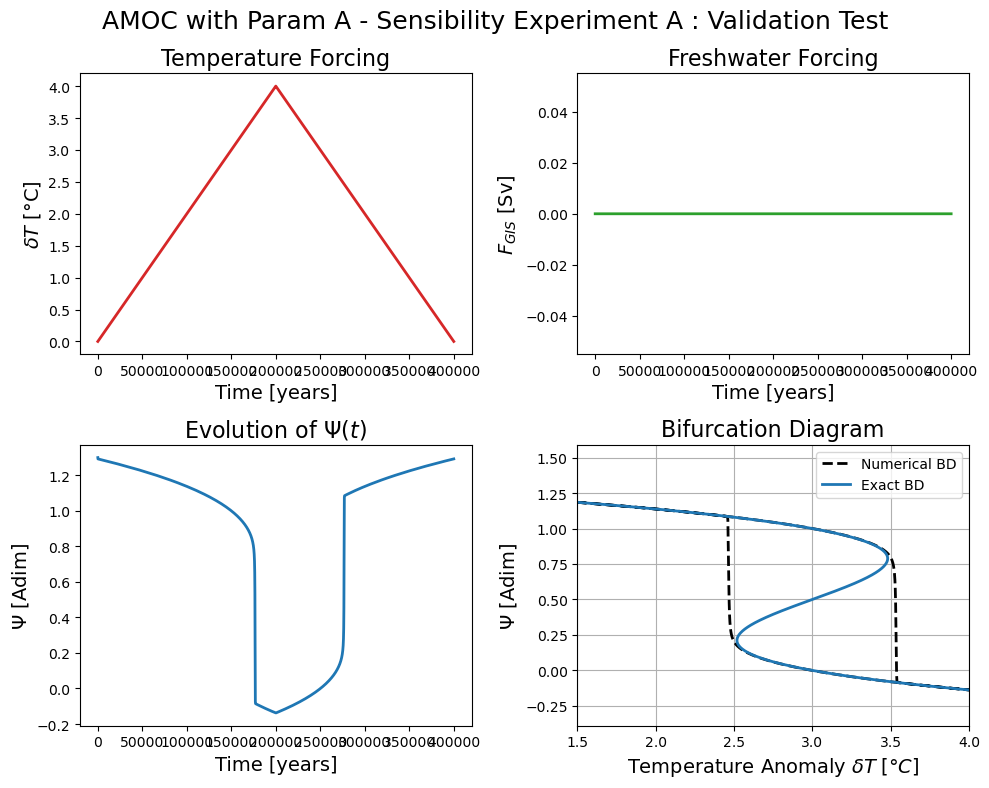

In [141]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,8))
ax1, ax2, ax3, ax4 = axes.flatten()

fig.suptitle("AMOC with Param A - Sensibility Experiment A : Validation Test", size=18)

ax1.plot(sol_ExpA.t, forcing_temperature(sol_ExpA.t), lw=2,color="tab:red")
ax1.set_title("Temperature Forcing", size=16)
ax1.set_xlabel("Time [years]", fontsize=14)
ax1.set_ylabel(r"$\delta T$ [°C]", fontsize=14)

ax2.plot(sol_ExpA.t, forcing_freshwater(sol_ExpA.t), lw=2,color="tab:green")
ax2.set_title("Freshwater Forcing", size=16)
ax2.set_xlabel("Time [years]", fontsize=14)
ax2.set_ylabel(r"$F_{GIS}$ [Sv]", fontsize=14)

ax3.plot(sol_ExpA.t, sol_ExpA.y[0], lw=2,color="tab:blue")
ax3.set_title("Evolution of " + r"$\Psi(t)$", size=16)
ax3.set_xlabel("Time [years]", fontsize=14)
ax3.set_ylabel(r"$\Psi$ [Adim]", fontsize=14)

ax4.plot(forcing_temperature(sol_ExpA.t), sol_ExpA.y[0], "k--", lw=2, label="Numerical BD")
ax4.plot(T,y_range,color="tab:blue", lw=2, label="Exact BD")
ax4.set_title("Bifurcation Diagram", size=16)
ax4.set_xlabel("Temperature Anomaly " + r"$\delta T \; [°C]$", fontsize=14)
ax4.set_ylabel(r"$\Psi$ [Adim]", fontsize=14)
ax4.set_xlim((1.5, 4))
ax4.grid()

plt.legend()
fig.tight_layout()
plt.savefig(save_fig_dir+'/Validation Test v2/EXPA', dpi=600, bbox_inches="tight")
plt.show()

### Step 3.1 - Computing associated critical values 

A first method which is also the easiest is to simply take the critical values visualy. 

Doing so we can roughly consider that :

- $\Psi^+ = 0.76$
- $\Psi^- = 0.245$
- $T^+ = 3.48°C$
- $T^- = 2.505°C$

A more rigourous method is to use a numerical computation. 

### Step 2.2 - Producing Hysteresis Experiment B

Simulation parameters


In [142]:
t0 = 0  # year for the start of the simulation
tend = 400000  # year for the end of the simulation
dt = 1  # iteration time step in years
y0 = [1.3]  # initial value

Parameterization of the forcing  

In [143]:
# Parameterization of the temperature forcing - T constant
T_cst = 0
forcing_temperature = interpolate.interp1d([t0,tend],[T_cst,T_cst],bounds_error= False, fill_value=0)

# Parameterization of the freshwater forcing 
F_forcing_max = 4
forcing_freshwater = interpolate.interp1d([t0,(t0+tend)/2,tend],[0,F_forcing_max,0],bounds_error= False, fill_value=0)

Solver

In [144]:
sol_ExpB = solve_ivp(f, [t0, tend], y0, method="RK45", rtol=10**-6, t_eval=teval)

Analytical expression of the bifurcation diagram. We are "not supposed" to know that but it will be used to see if our simulations parameters are roughly good in order to retrive the exact bifurcation diagram. It will be also useful four the comparison with the bifurcation diagram of our simplified model.

In [145]:
y_range = np.linspace(-0.3,1.5,1000)
F = (y_range**3-a1_star*y_range**2-b1_star*y_range-c1_star-d1_star*T_cst)/e12_star

Plot

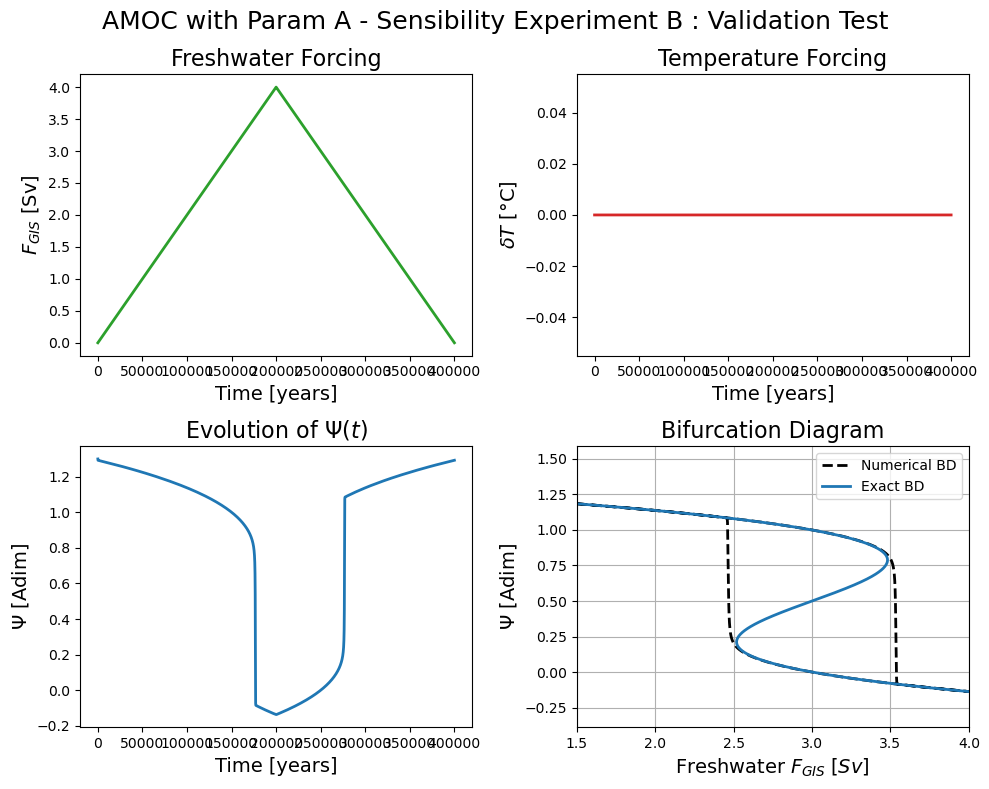

In [146]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,8))
ax1, ax2, ax3, ax4 = axes.flatten()

fig.suptitle("AMOC with Param A - Sensibility Experiment B : Validation Test", size=18)

ax1.plot(sol_ExpB.t, forcing_freshwater(sol_ExpB.t), lw=2, color="tab:green")
ax1.set_title("Freshwater Forcing", size=16)
ax1.set_xlabel("Time [years]", size=14)
ax1.set_ylabel(r"$F_{GIS}$ [Sv]", size=14)

ax2.plot(sol_ExpB.t, forcing_temperature(sol_ExpB.t), lw=2, color="tab:red")
ax2.set_title("Temperature Forcing", size=16)
ax2.set_xlabel("Time [years]", size=14)
ax2.set_ylabel(r"$\delta T$ [°C]", size=14)

ax3.plot(sol_ExpB.t, sol_ExpB.y[0], lw=2, color="tab:blue")
ax3.set_title("Evolution of " + r"$\Psi(t)$", size=16)
ax3.set_xlabel("Time [years]", size=14)
ax3.set_ylabel(r"$\Psi$ [Adim]", size=14)

ax4.plot(forcing_freshwater(sol_ExpB.t), sol_ExpB.y[0], "k--", lw=2, label="Numerical BD")
ax4.plot(F,y_range,color="tab:blue", lw=2, label="Exact BD")
ax4.set_title("Bifurcation Diagram", size=16)
ax4.set_xlabel("Freshwater " + r"$F_{GIS} \; [Sv]$", size=14)
ax4.set_ylabel(r"$\Psi$ [Adim]", size=14)
ax4.set_xlim((1.5, 4))
ax4.grid()

plt.legend()
fig.tight_layout()
plt.savefig(save_fig_dir+'/Validation Test v2/EXPB', dpi=600, bbox_inches="tight")
plt.show()

### Step 3.2 - Computing associated critical values 

A first method which is also the easiest is to simply take the critical values visualy. 

Doing so we can roughly consider that :

- $\Psi^+ = 0.76$
- $\Psi^- = 0.245$
- $F_{GIS}^+ = 3.48 Sv$
- $F_{GIS}^- = 2.505Sv$

A more rigourous method is to use a numerical computation. 

### Step 4 - Computating of the calibrated coefficient based on the module

Now based on the critical bifurcations points coordinates from the two hysteres experiment we will "forgot" from which model them comes and only use the coordinates. We want to set those coordinates as input of our calibration algorithm and see if we can retrieve the "forgoten" coefficients. 

In [147]:
valid_test_AMOC_crit_params = [0.76,0.245,3.48,2.505,3.48,2.505,50,50]
valid_test_calib_coef = calib_module_AMOC_ParamA(valid_test_AMOC_crit_params[0], valid_test_AMOC_crit_params[1], valid_test_AMOC_crit_params[2], valid_test_AMOC_crit_params[3], valid_test_AMOC_crit_params[4], valid_test_AMOC_crit_params[5], F_cst, T_cst)

a_AMOC = valid_test_calib_coef[0]
b_AMOC = valid_test_calib_coef[1]
c_AMOC = valid_test_calib_coef[5]
c_bis = valid_test_calib_coef[4]
d_AMOC = valid_test_calib_coef[2]
e_AMOC = valid_test_calib_coef[3]

### Step 5 - Comparison between initial data and simplified model

#### Coefficient comparison

In [148]:
## Global error computation ## 
err = np.sqrt((a1_star-a_AMOC)**2 + (b1_star-b_AMOC)**2 + (c1_star-c_AMOC)**2 + (d1_star-d_AMOC)**2 + (e12_star-e_AMOC)**2)

## Output ##
print("-----------------------------------------------------------")
print("Original arbitrarily fixed coefficient values")
print("-----------------------------------------------------------")
print("a_star = {:.3f}".format(a1_star))
print("b_star = {:.3f}".format(b1_star))
print("c_star = {:.3f}".format(c1_star))
print("d_star = {:.3f}".format(d1_star))
print("e_star = {:.3f}".format(e12_star))
print("-----------------------------------------------------------")
print("Calibrated coefficient values")
print("-----------------------------------------------------------")
print("a = {:.3f}".format(a_AMOC))
print("b = {:.3f}".format(b_AMOC))
print("c = {:.3f}".format(c_AMOC))
print("c_bis = {:.3f}".format(c_bis))
print("d = {:.3f}".format(d_AMOC))
print("e = {:.3f}".format(e_AMOC))
print("------------------------------------------------------------------")
print("Global error between initial and calibrated coeficients = {:.3f}".format(err))
print("Error on coef a = {:.2f}%".format(np.abs(((a_AMOC-a1_star)/a_AMOC))*100))
print("Error on coef b = {:.2f}%".format(np.abs(((b_AMOC-b1_star))/b_AMOC)*100))
print("Error on coef c = {:.2f}%".format(np.abs(((c_AMOC-c1_star))/c_AMOC)*100))
print("Error on coef d = {:.2f}%".format(np.abs(((d_AMOC-d1_star))/d_AMOC)*100))
print("Error on coef e = {:.2f}%".format(np.abs(((e_AMOC-e12_star))/e_AMOC)*100))
print("------------------------------------------------------------------")

-----------------------------------------------------------
Original arbitrarily fixed coefficient values
-----------------------------------------------------------
a_star = 1.500
b_star = -0.500
c_star = 0.300
d_star = -0.100
e_star = -0.100
-----------------------------------------------------------
Calibrated coefficient values
-----------------------------------------------------------
a = 1.507
b = -0.559
c = 0.237
c_bis = 0.237
d = -0.070
e = -0.070
------------------------------------------------------------------
Global error between initial and calibrated coeficients = 0.096
Error on coef a = 0.50%
Error on coef b = 10.49%
Error on coef c = 26.83%
Error on coef d = 42.76%
Error on coef e = 42.76%
------------------------------------------------------------------


#### Bifurcation Diagram comparison

Computation of the analytic bifurcation diagram for temperature based on the calibration module

In [149]:
T_calib_module = (y_range**3-a_AMOC*y_range**2-b_AMOC*y_range-c_AMOC-e_AMOC*F_cst)/d_AMOC

Plot

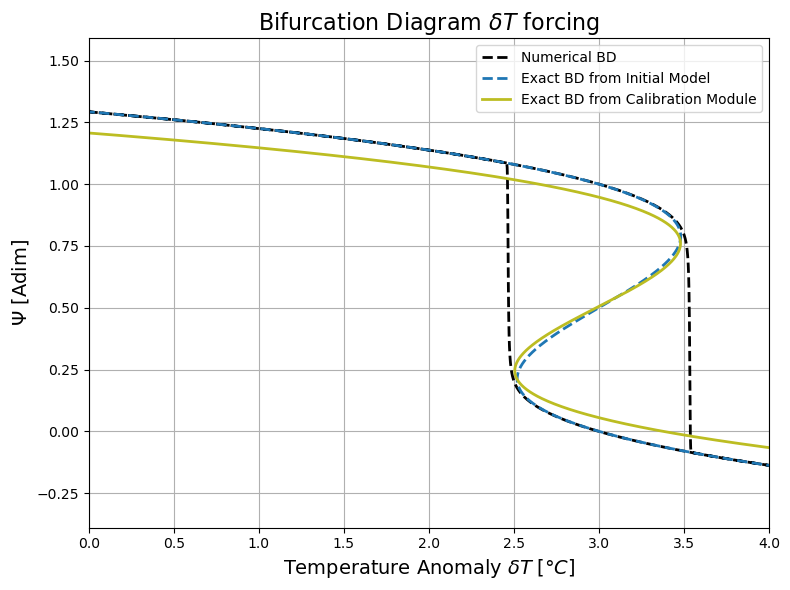

In [150]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

forcing_temperature = interpolate.interp1d([t0,(t0+tend)/2,tend],[0,T_forcing_max,0],bounds_error= False, fill_value=0)

ax.plot(forcing_temperature(sol_ExpA.t), sol_ExpA.y[0], "k--", lw=2, label="Numerical BD")
ax.plot(T,y_range,'--',color="tab:blue", lw=2, label="Exact BD from Initial Model")
ax.plot(T_calib_module,y_range,color="tab:olive", lw=2, label="Exact BD from Calibration Module")
ax.set_title("Bifurcation Diagram " + r"$\delta T $ forcing", size=16)
ax.set_xlabel("Temperature Anomaly " + r"$\delta T \; [°C]$", fontsize=14)
ax.set_ylabel(r"$\Psi$ [Adim]", fontsize=14)
ax.set_xlim((0, 4))
ax.grid()

plt.legend()
fig.tight_layout()
plt.savefig(save_fig_dir+'/Validation Test v2/Bif_diag_Comp_Temp', dpi=600, bbox_inches="tight")
plt.show()

Computation of the analytic bifurcation diagram for freshwater based on the calibration module

In [151]:
F_calib_module = (y_range**3-a_AMOC*y_range**2-b_AMOC*y_range-c_AMOC-d_AMOC*T_cst)/e_AMOC

Plot

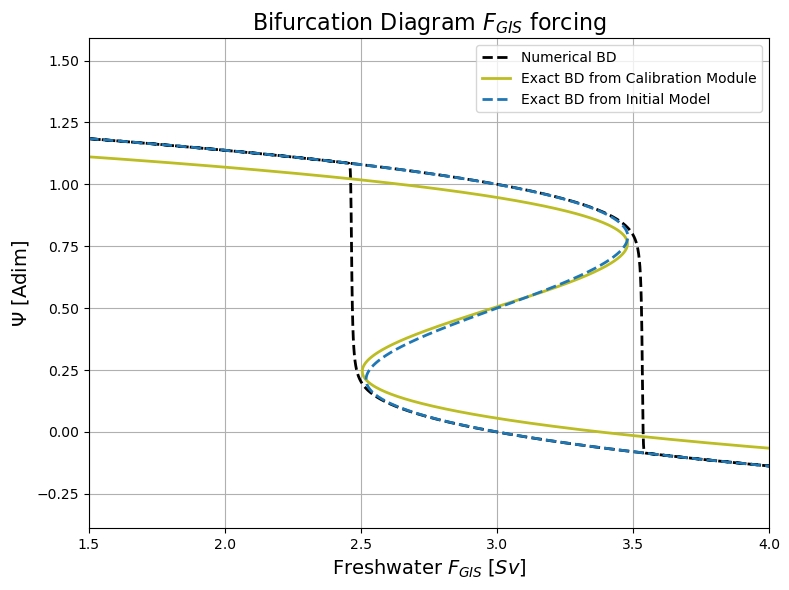

In [152]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

ax.plot(forcing_freshwater(sol_ExpB.t), sol_ExpB.y[0], "k--", lw=2, label="Numerical BD")
ax.plot(F_calib_module,y_range,color="tab:olive", lw=2, label="Exact BD from Calibration Module")
ax.plot(F,y_range,'--',color="tab:blue", lw=2, label="Exact BD from Initial Model")
ax.set_title("Bifurcation Diagram " + r"$F_{GIS} $ forcing", size=16)
ax.set_xlabel("Freshwater " + r"$F_{GIS} \; [Sv]$", size=14)
ax.set_ylabel(r"$\Psi$ [Adim]", size=14)
ax.set_xlim((1.5, 4))
ax.grid()

plt.legend()
fig.tight_layout()
plt.savefig(save_fig_dir+'/Validation Test v2/Bif_diag_Comp_F', dpi=600, bbox_inches="tight")
plt.show()

---

## Results Analysis

---

### Phase Portrait - AMOC

Phase portrait of the $\frac{d\Psi}{dt} = f(\Psi)$ function, Eq.(1) and computation of the equilibrium points

In [153]:
### Computation of the equilibirum points of equation (1) ###

eq_points_1 = fsolve(dPsi_dt, -0.5, args=(T_B, F_A, AMOC_crit_params))
eq_points_2 = fsolve(dPsi_dt, 0.5, args=(T_B, F_A, AMOC_crit_params))
eq_points_3 = fsolve(dPsi_dt, 1.25, args=(T_B, F_A, AMOC_crit_params))

eq_points = [eq_points_1, eq_points_2, eq_points_3]

### Plot of the phase portrait Eq.(1) with equilibrium points ###
N = 1000
Psi = np.linspace(-0.1, 1.1, N)
Y = np.zeros(N)
for i in range(N):
    y = dPsi_dt(Psi[i], T_forcing=T_B, F_forcing=F_A, model_parameters=AMOC_crit_params)
    Y[i] = y
    
fig, ax = plt.subplots(1,1,figsize=(15,7))

ax.plot(Psi, Y, label = r"$f(\Psi, T, F)$", lw=2)
#ax.plot(Psi, Z, label = "ExpA")
plt.axhline(y=0, color="black", label="$\dot{\Psi}=0$")
for i in range(3):
    plt.plot(eq_points[i], dPsi_dt(eq_points[i], T_B, F_A, AMOC_crit_params), "ko")
ax.set_xlabel(r"$\Psi$", fontsize = 16)
ax.set_ylabel(r"$\dot{\Psi}$", fontsize = 16)
ax.set_title("Phase portrait of "+r"$\frac{d\Psi}{dt} = f(\Psi, T_\Psi, F)$"+" with "+r"$T$={}°C,".format(T_B)+r" $F={}\,Sv$".format(F_A), fontsize = 16)
ax.legend(fontsize = 12)
plt.grid()
plt.plot()

<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
C:\Users\AL000111\AppData\Local\Temp\ipykernel_12940\4071003266.py:21: SyntaxWarning: invalid escape sequence '\d'
  plt.axhline(y=0, color="black", label="$\dot{\Psi}=0$")


[]

### Phase Portrait - GIS

Phase portrait of the $\frac{dV}{dt} = g(V)$ function, Eq.(4) and computation of the equilibrium points

In [154]:
### Computation of the equilibirum points of equation (1) ###

T_D = 1.2
Psi_C= 1

eq_points_1 = fsolve(dV_dt, 0.2, args=(T_D, Psi_C, GIS_crit_params))
eq_points_2 = fsolve(dV_dt, 0.5, args=(T_D, Psi_C, GIS_crit_params))
eq_points_3 = fsolve(dV_dt, 1.25, args=(T_D, Psi_C, GIS_crit_params))

eq_points = [eq_points_1, eq_points_2, eq_points_3]

### Plot of the phase portrait Eq.(1) with equilibrium points ###
N = 1000
V = np.linspace(-0.1, 1.1, N)
Y = np.zeros(N)
#Z = np.zeros(N)
for i in range(N):
    y = dV_dt(V[i], T_D, Psi_C, GIS_crit_params)
    Y[i] = y

stable_V_left = np.linspace(-0.1,eq_points_1,N)
unstable_V = np.linspace(eq_points_1,eq_points_3,N)
stable_V_right = np.linspace(eq_points_3,1.1,N)

Y_stable_left = np.zeros(N)
for i in range(N):
    y = dV_dt(stable_V_left[i], T_D, Psi_C, GIS_crit_params)
    Y_stable_left[i] = y

Y_unstable = np.zeros(N)
for i in range(N):
    y = dV_dt(unstable_V[i], T_D, Psi_C, GIS_crit_params)
    Y_unstable[i] = y

Y_stable_right = np.zeros(N)
for i in range(N):
    y = dV_dt(stable_V_right[i], T_D, Psi_C, GIS_crit_params)
    Y_stable_right[i] = y

fig, ax = plt.subplots(1,1,figsize=(10,7))

ax.plot(V, Y, label = r"$g(V, T_V, \Psi_V)$ stable branch", lw=3)
plt.axhline(y=0, color="black", label="$\dot{V}=0$",lw=3)

# ax.plot(stable_V_left,Y_stable_left,label = r"$g(V, T_V, \Psi_V)$ stable branch", lw=3,color='tab:blue')
# ax.plot(unstable_V,Y_unstable,label = r"$g(V, T_V, \Psi_V)$ unstable branch",color='tab:orange', lw=3)
# ax.plot(stable_V_right,Y_stable_right, lw=3,color='tab:blue')

plt.plot(eq_points[0], dV_dt(eq_points[0], T_D, Psi_C, GIS_crit_params), "ko",markersize=14,color='tab:green',label='Stable Equilibria')
plt.plot(eq_points[2], dV_dt(eq_points[2], T_D, Psi_C, GIS_crit_params), "ko",markersize=14,color='tab:green')
plt.plot(eq_points[1], dV_dt(eq_points[1], T_D, Psi_C, GIS_crit_params), "o",markersize=14,color='tab:orange',label='Unstable Equilibria')

ax.annotate('', xy=(0.1, 0), xytext=(0.0, 0),
            arrowprops=dict(facecolor='black', shrink=0.1))

ax.annotate('', xy=(0.25, 0), xytext=(0.35, 0),
            arrowprops=dict(facecolor='black', shrink=0.1))

ax.annotate('', xy=(0.45, 0), xytext=(0.55, 0),
            arrowprops=dict(facecolor='black', shrink=0.1))

ax.annotate('', xy=(0.80, 0), xytext=(0.70, 0),
            arrowprops=dict(facecolor='black', shrink=0.1))

ax.annotate('', xy=(1, 0), xytext=(1.1, 0),
            arrowprops=dict(facecolor='black', shrink=0.1))

ax.set_xlabel(r"$V$", fontsize = 20)
ax.set_ylabel(r"$\dot{V}$", fontsize = 20)
ax.tick_params(axis='both',labelsize=13)
ax.set_title("Phase portrait of "+r"$\frac{dV}{dt} = g(V, T, \Psi)$"+" with "+r"$T$={}°C,".format(T_D)+r" $\Psi={}$".format(Psi_C), fontsize = 20)
ax.legend(fontsize = 19)
plt.tight_layout()
plt.grid()
plt.plot()
plt.savefig(save_fig_dir_mem+'Phase Portrait1.png',dpi=400)

<>:43: SyntaxWarning: invalid escape sequence '\d'
<>:43: SyntaxWarning: invalid escape sequence '\d'
C:\Users\AL000111\AppData\Local\Temp\ipykernel_12940\2937682984.py:43: SyntaxWarning: invalid escape sequence '\d'
  plt.axhline(y=0, color="black", label="$\dot{V}=0$",lw=3)
C:\Users\AL000111\AppData\Local\Temp\ipykernel_12940\2937682984.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y_stable_left[i] = y
C:\Users\AL000111\AppData\Local\Temp\ipykernel_12940\2937682984.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y_unstable[i] = y
C:\Users\AL000111\AppData\Local\Temp\ipykernel_12940\2937682984.py:38: DeprecationWarning: Conve

<>:43: SyntaxWarning: invalid escape sequence '\d'
<>:43: SyntaxWarning: invalid escape sequence '\d'
C:\Users\AL000111\AppData\Local\Temp\ipykernel_12940\489349803.py:43: SyntaxWarning: invalid escape sequence '\d'
  plt.axhline(y=0, color="black", label="$\dot{V}=0$",lw=3)
C:\Users\AL000111\AppData\Local\Temp\ipykernel_12940\489349803.py:7: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  eq_points_2 = fsolve(dV_dt, 0.5, args=(T_D, Psi_C, GIS_crit_params))
C:\Users\AL000111\AppData\Local\Temp\ipykernel_12940\489349803.py:8: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  eq_points_3 = fsolve(dV_dt, 1.25, args=(T_D, Psi_C, GIS_crit_params))
C:\Users\AL000111\AppData\Local\Temp\ipykernel_12940\489349803.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure

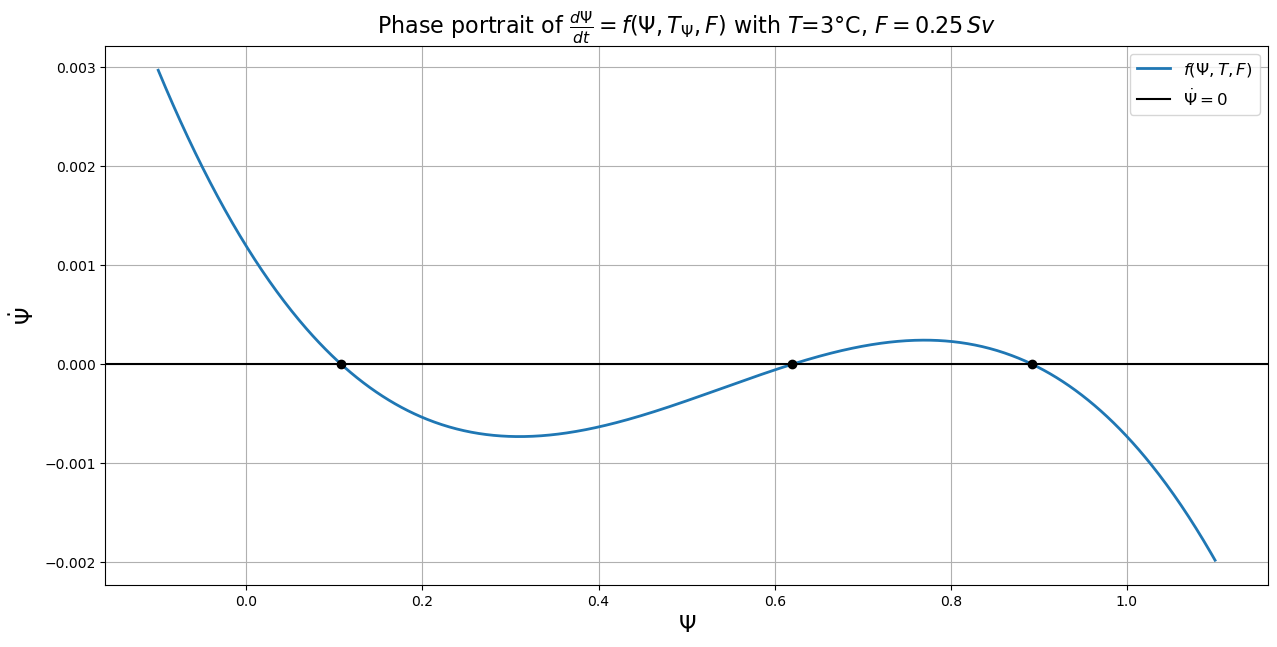

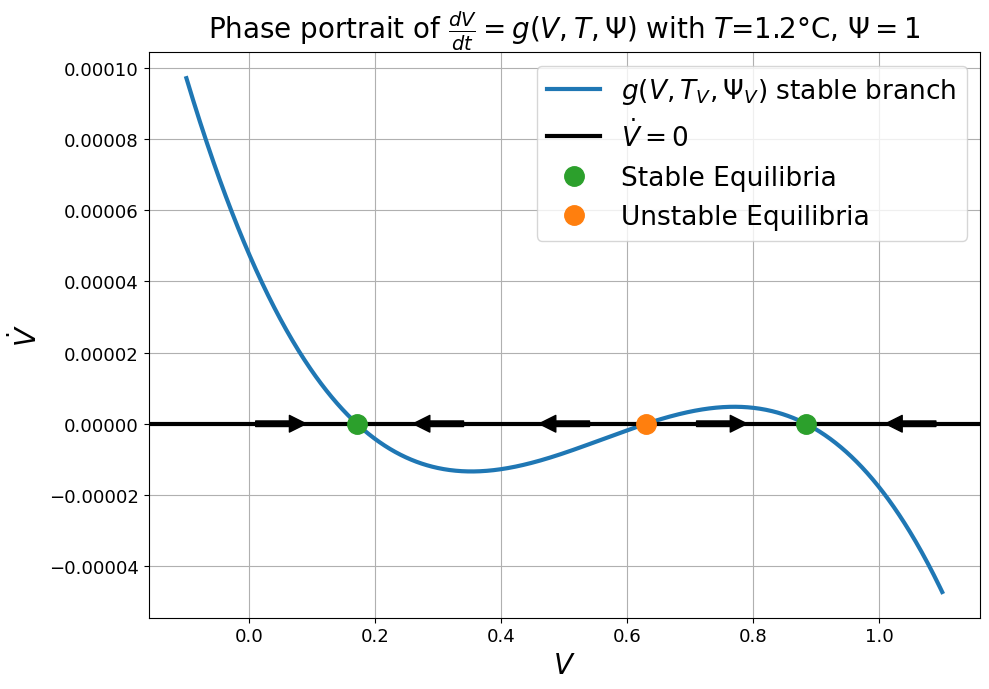

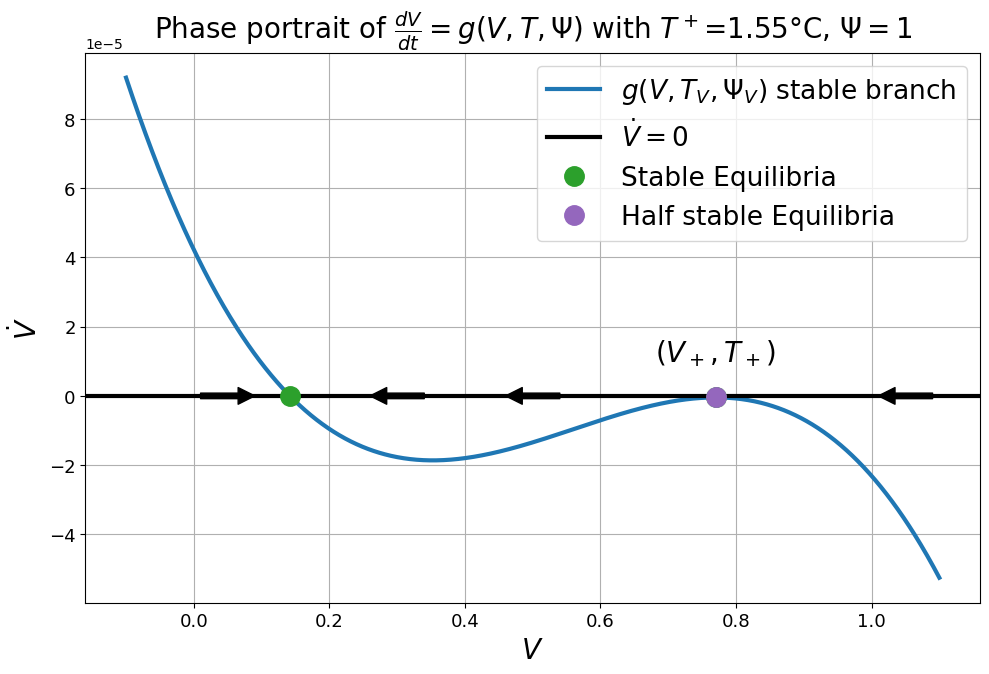

In [155]:
### Computation of the equilibirum points of equation (1) ###

T_D = 1.55
Psi_C= 1

eq_points_1 = fsolve(dV_dt, 0.2, args=(T_D, Psi_C, GIS_crit_params))
eq_points_2 = fsolve(dV_dt, 0.5, args=(T_D, Psi_C, GIS_crit_params))
eq_points_3 = fsolve(dV_dt, 1.25, args=(T_D, Psi_C, GIS_crit_params))

eq_points = [eq_points_1, eq_points_2, eq_points_3]

### Plot of the phase portrait Eq.(1) with equilibrium points ###
N = 1000
V = np.linspace(-0.1, 1.1, N)
Y = np.zeros(N)
#Z = np.zeros(N)
for i in range(N):
    y = dV_dt(V[i], T_D, Psi_C, GIS_crit_params)
    Y[i] = y

stable_V_left = np.linspace(-0.1,eq_points_1,N)
unstable_V = np.linspace(eq_points_1,eq_points_3,N)
stable_V_right = np.linspace(eq_points_3,1.1,N)

Y_stable_left = np.zeros(N)
for i in range(N):
    y = dV_dt(stable_V_left[i], T_D, Psi_C, GIS_crit_params)
    Y_stable_left[i] = y

Y_unstable = np.zeros(N)
for i in range(N):
    y = dV_dt(unstable_V[i], T_D, Psi_C, GIS_crit_params)
    Y_unstable[i] = y

Y_stable_right = np.zeros(N)
for i in range(N):
    y = dV_dt(stable_V_right[i], T_D, Psi_C, GIS_crit_params)
    Y_stable_right[i] = y

fig, ax = plt.subplots(1,1,figsize=(10,7))

ax.plot(V, Y, label = r"$g(V, T_V, \Psi_V)$ stable branch", lw=3)
plt.axhline(y=0, color="black", label="$\dot{V}=0$",lw=3)

# ax.plot(stable_V_left,Y_stable_left,label = r"$g(V, T_V, \Psi_V)$ stable branch", lw=3,color='tab:blue')
# ax.plot(unstable_V,Y_unstable,label = r"$g(V, T_V, \Psi_V)$ unstable branch",color='tab:orange', lw=3)
# ax.plot(stable_V_right,Y_stable_right, lw=3,color='tab:blue')

plt.plot(eq_points[0], dV_dt(eq_points[0], T_D, Psi_C, GIS_crit_params), "ko",markersize=14,color='tab:green',label='Stable Equilibria')
plt.plot(eq_points[2], dV_dt(eq_points[2], T_D, Psi_C, GIS_crit_params), "ko",markersize=14,color='tab:green')
plt.plot(eq_points[1], dV_dt(eq_points[1], T_D, Psi_C, GIS_crit_params), "o",markersize=14,color='tab:purple',label='Half stable Equilibria')

ax.annotate('', xy=(0.1, 0), xytext=(0.0, 0),
            arrowprops=dict(facecolor='black', shrink=0.1))

ax.annotate('', xy=(0.25, 0), xytext=(0.35, 0),
            arrowprops=dict(facecolor='black', shrink=0.1))

ax.annotate('', xy=(0.45, 0), xytext=(0.55, 0),
            arrowprops=dict(facecolor='black', shrink=0.1))


ax.annotate('', xy=(1, 0), xytext=(1.1, 0),
            arrowprops=dict(facecolor='black', shrink=0.1))

plt.text(0.68,0.00001,r'$(V_+,T_+)$',fontsize=20)

ax.set_xlabel(r"$V$", fontsize = 20)
ax.set_ylabel(r"$\dot{V}$", fontsize = 20)
ax.tick_params(axis='both',labelsize=13)
ax.set_title("Phase portrait of "+r"$\frac{dV}{dt} = g(V, T, \Psi)$"+" with "+r"$T^+$={}°C,".format(T_D)+r" $\Psi={}$".format(Psi_C), fontsize = 20)
ax.legend(fontsize = 19)
plt.tight_layout()
plt.grid()
plt.savefig(save_fig_dir_mem+'Phase Portrait2.png',dpi=400)
plt.show()


### Bifurcation Diagram

#### AMOC - Bifurcation Diagram

In order to find the bifurcation diagram we will try two differents methods cfr [[Note de Travail - Cadre Algorithmique Coefficients de Couplage]].

The **first method** is to isolate the expression of the forcing consider with respect to the value of the dynamic variable $\Psi$ at equilibrium noted $\psi$. For the **sensitivity experiment A** this relation is equal to
$$ T = (\psi^3-a_1\psi^2-b_1\psi-c_1-e_{12}F_{GIS}^A)\frac{1}{d_1} = T(\psi) \quad (7) $$ 

The idea is to plot this relation and then invert it in order to have the $(T,\psi(T))$ graph which is our bifurcation diagram.

For the **sensitivity experiment B** this relation is equal to

$$ F_{GIS} = (\psi^3-a_1\psi^2-b_1\psi-c_1-d_1T^B)\frac{1}{e_{12}} \quad (8) $$ 

The **second method** is to define a more general algorithm for finding explicitly the roots of Eq.(1) by iterating the fsolve() function of scipy with different initial conditions in order to get all the roots since we can have up to three roots, three equilibria for the same value of the forcing. This should not be hard to do but since the first method is easier to implement and gives good results I will not take the research further for the moment for the second method.



In [156]:
# Definition of the function folowing Eq.(7) and Eq.(8) # 
def T_funct_psi(psi):
  return ((psi**3 - a_AMOC*(psi**2) - b_AMOC*psi - c_AMOC - e_AMOC*F_A)*(1/d_AMOC))

def F_funct_psi(psi):
  return ((psi**3 - a_AMOC*(psi**2) - b_AMOC*psi - c_AMOC - d_AMOC*T_B)*(1/e_AMOC))

# Computation of the functions # 
dx=0.01
psi_range = np.arange(-0.2,1.2,dx)
T_fct_psi = T_funct_psi(psi_range)
F_fct_psi = F_funct_psi(psi_range)

# Classification of the unstable branche # 

unstable_psi = np.arange(AMOC_crit_params[1], AMOC_crit_params[0], dx)
T_fct_psi_unstable = T_funct_psi(unstable_psi)
F_fct_psi_unstable = F_funct_psi(unstable_psi)

Plot of the $(\psi, T(\psi))$ graph

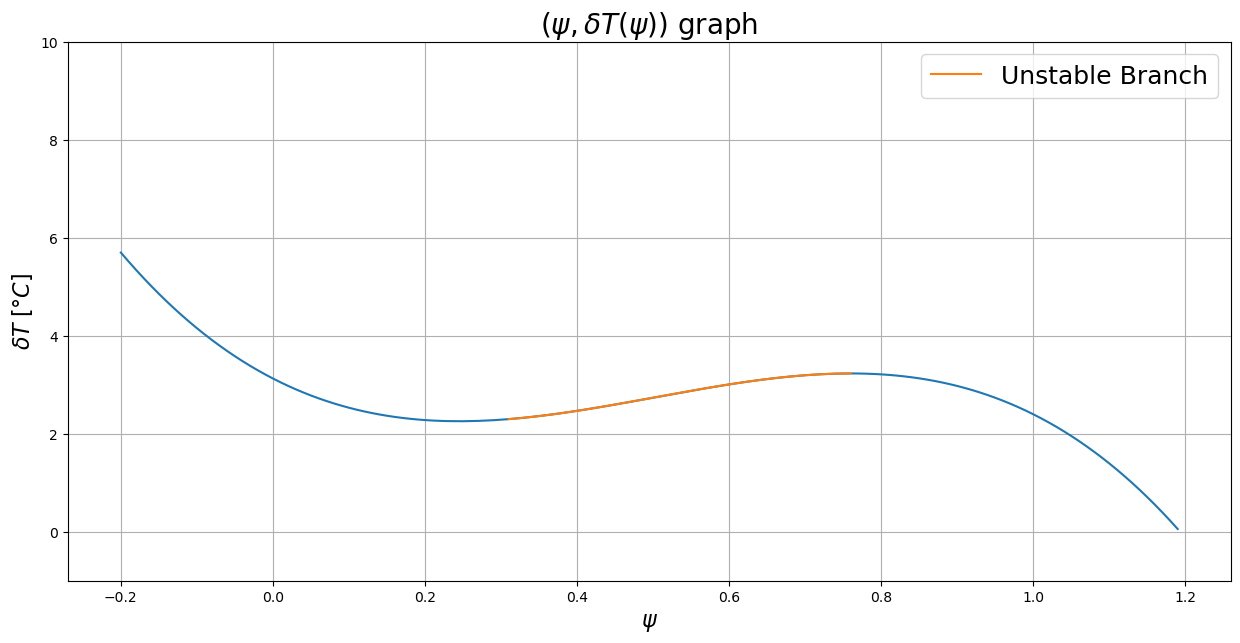

In [157]:
fig, ax = plt.subplots(1,1,figsize=(15,7))

plt.plot(psi_range, T_fct_psi)
plt.plot(unstable_psi, T_fct_psi_unstable, color = "tab:orange", label="Unstable Branch")
ax.set_xlabel(r"$\psi$", fontsize=16)
ax.set_ylabel(r"$\delta T\;[°C]$", fontsize=16)
ax.set_ybound([-1,10])
plt.title(r"$(\psi, \delta T(\psi))$ graph", fontsize = 20)
plt.legend(fontsize=18)
plt.grid()

plt.show()

Plot of the $(T, \psi(T))$ graph - Bifurcation diagram of $\delta T$

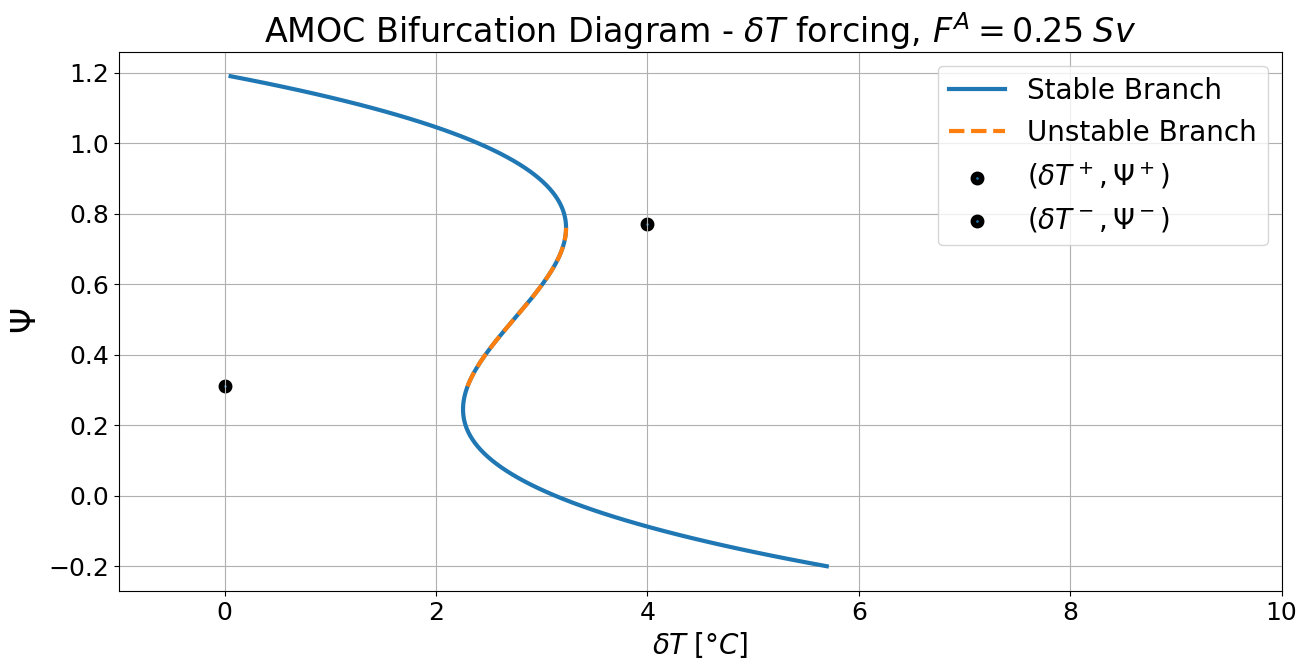

In [158]:
### Plotting ###

fig, ax = plt.subplots(1,1,figsize=(15,7))

## Plot of the bifurcation diagram ##
plt.plot(T_fct_psi, psi_range, label="Stable Branch", lw=3)
plt.plot(T_fct_psi_unstable, unstable_psi, color="tab:orange", label="Unstable Branch", lw=3, linestyle="dashed")

## Plot of the critical points ##
plt.scatter(AMOC_crit_params[2],AMOC_crit_params[0], marker='o', color="#1f77b4", linewidths=4, edgecolors="black", label=r"$(\delta T^+, \Psi^+)$")
plt.scatter(AMOC_crit_params[3],AMOC_crit_params[1], marker='o', color="#1f77b4", linewidths=4, edgecolors="black", label=r"$(\delta T^-, \Psi^-)$")

## Plot cosmetics ##
ax.set_xlabel(r"$\delta T\;[°C]$", fontsize=20)
ax.set_ylabel(r"$\Psi$", fontsize=24)
ax.set_xbound([-1,10])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(r"AMOC Bifurcation Diagram - $\delta T$ forcing, $F^A = {} \;Sv$".format(F_A), fontsize = 24)
plt.legend(fontsize=20)
plt.grid()

plt.show()



# Linux ThinkPad path fig.savefig(r"/home/amaury/Bureau/LPHYS2299 - Master's Thesis/Code/AMOC-GIS Tipping Module/Tipping Module Calibration - Param A/Figures/Bifurcation Diagram/AMOC_T_BD_FA={}.png".format(F_A))
fig.savefig(r"C:\Users\AL000111\Documents\Mémoire\Code\LPHYS2299-Master-s-Thesis\AMOC-GIS Tipping Module\Tipping Module Calibration - Param A\Figures\Bifurcation Diagram\AMOC_T_BD_FA={}.png".format(F_A))

Plot of the $(\psi, F_{GIS}(\psi))$ graph

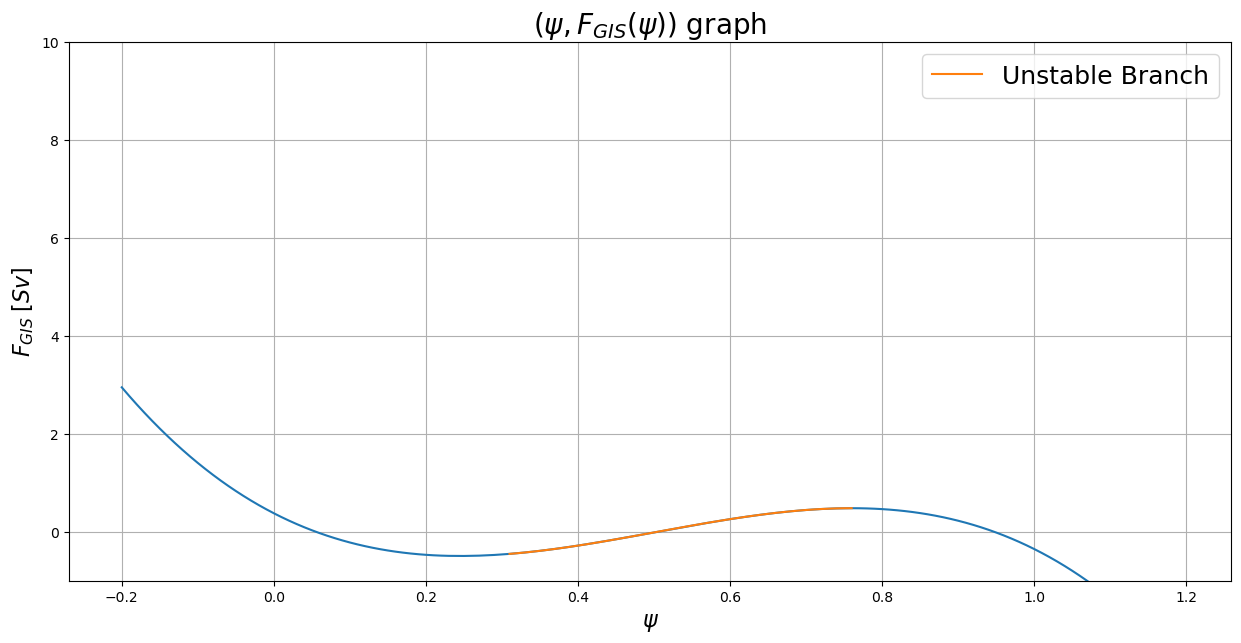

In [159]:
fig, ax = plt.subplots(1,1,figsize=(15,7))

plt.plot(psi_range, F_fct_psi)
plt.plot(unstable_psi, F_fct_psi_unstable, color = "tab:orange", label="Unstable Branch")
ax.set_xlabel(r"$\psi$", fontsize=16)
ax.set_ylabel(r"$F_{GIS}\;[Sv]$", fontsize=16)
ax.set_ybound([-1,10])
plt.title(r"$(\psi, F_{GIS}(\psi))$ graph", fontsize = 20)
plt.legend(fontsize=18)
plt.grid()

plt.show()

Plot of the $(F_{GIS}, \psi(F_{GIS}))$ graph - Bifurcation diagram of $F_{GIS}$

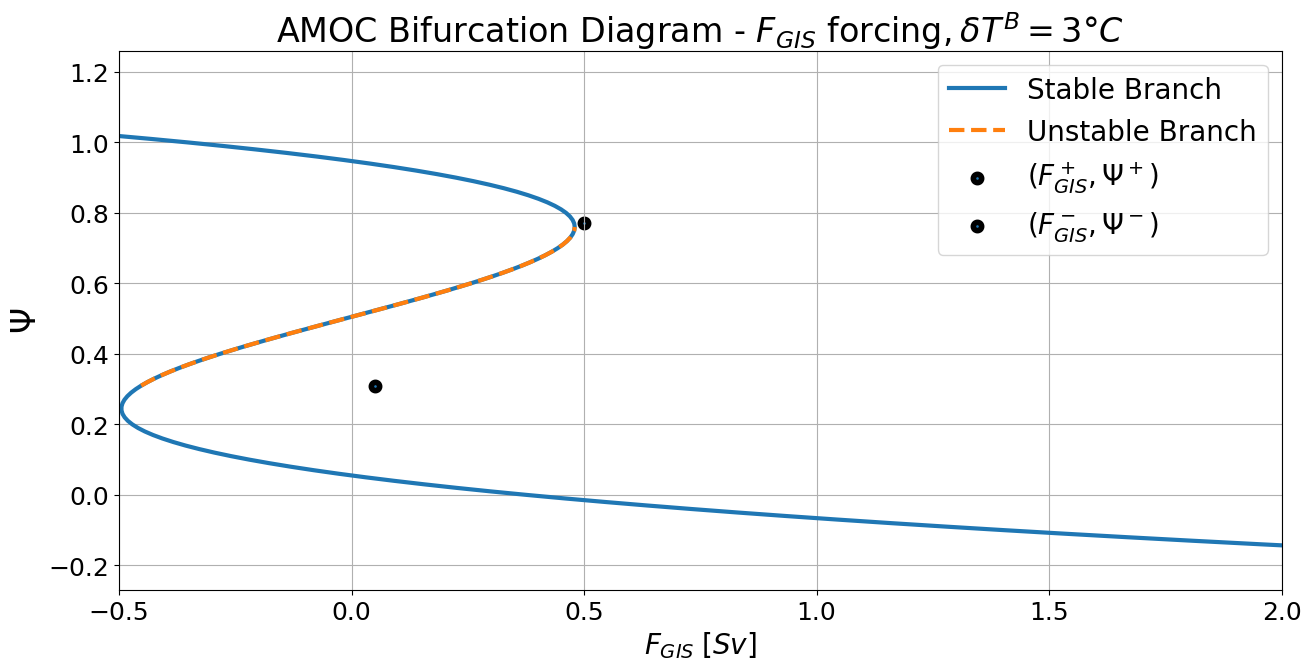

In [160]:
### Plotting ###

fig, ax = plt.subplots(1,1,figsize=(15,7))

## Plot of the bifurcation diagram ##
plt.plot(F_fct_psi, psi_range, label="Stable Branch", lw=3)
plt.plot(F_fct_psi_unstable, unstable_psi, color="tab:orange", label="Unstable Branch", lw=3, linestyle="dashed")

## Plot of the critical points ##
plt.scatter(AMOC_crit_params[4],AMOC_crit_params[0], marker='o', color="#1f77b4", linewidths=4, edgecolors="black", label=r"$(F_{GIS}^+, \Psi^+)$")
plt.scatter(AMOC_crit_params[5],AMOC_crit_params[1], marker='o', color="#1f77b4", linewidths=4, edgecolors="black", label=r"$(F_{GIS}^-, \Psi^-)$")

## Plot cosmetics ##
ax.set_xlabel(r"$F_{GIS}\;[Sv]$", fontsize=20)
ax.set_ylabel(r"$\Psi$", fontsize=24)
ax.set_xbound([-0.5,2])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(r"AMOC Bifurcation Diagram - $F_{GIS}$ forcing,"+r"$ \:\delta T^B = {}°C$".format(T_B), fontsize = 24)
plt.legend(fontsize=20)
plt.grid()

plt.show()

# Linux ThinkPad path fig.savefig(r"/home/amaury/Bureau/LPHYS2299 - Master's Thesis/Code/AMOC-GIS Tipping Module/Tipping Module Calibration - Param A/Figures/Bifurcation Diagram/AMOC_FGIS_BD_TB={}.png".format(T_B))
fig.savefig(r"C:\Users\AL000111\Documents\Mémoire\Code\LPHYS2299-Master-s-Thesis\AMOC-GIS Tipping Module\Tipping Module Calibration - Param A\Figures\Bifurcation Diagram\AMOC_FGIS_BD_TB={}.png".format(T_B))

#### GIS - Bifurcation Diagram

Following the **first method** for finding the roots described above we wish to isolate the expression of the forcing parameter with respect to the value of the dynamic variable $V$ at equilibrium noted $v$. For the sensitivity experiment C this relation is equal to

$$ T_V = (v^3-a_2v^2-b_2v-c_2-e_{21}(1-\Psi^C))\frac{1}{d_2} = T_V(v)\quad (9)  $$ 

Again we will plot this relation and then invert it to have the $(T_V,v(T_V))$ graph which is our bifurcation diagram.

In [161]:
# Definition of the function folowing Eq.(9) and Eq.(10) # 
def Tv_funct_v(v):
    return ((v**3 - a_GIS*(v**2) - b_GIS*v - c_GIS - e_GIS*(1-Psi_C))*(1/d_GIS))
def Psi_funct_v(v):
    return (1 - (v**3 - a_GIS*(v**2) - b_GIS*v - c_GIS - d_GIS*T_D)*(1/e_GIS))

# Computation of the functions # 
dx=0.01
v_range = np.arange(0,1.2,dx)
Tv_fct_v = Tv_funct_v(v_range)
Psi_fct_v = Psi_funct_v(v_range)

# Classification of the unstable branche # 

unstable_v = np.arange(GIS_crit_params[1], GIS_crit_params[0], dx)
Tv_fct_v_unstable = Tv_funct_v(unstable_v)
Psi_fct_v_unstable = Psi_funct_v(unstable_v)

Plot of the $(v, T_V(v))$ graph

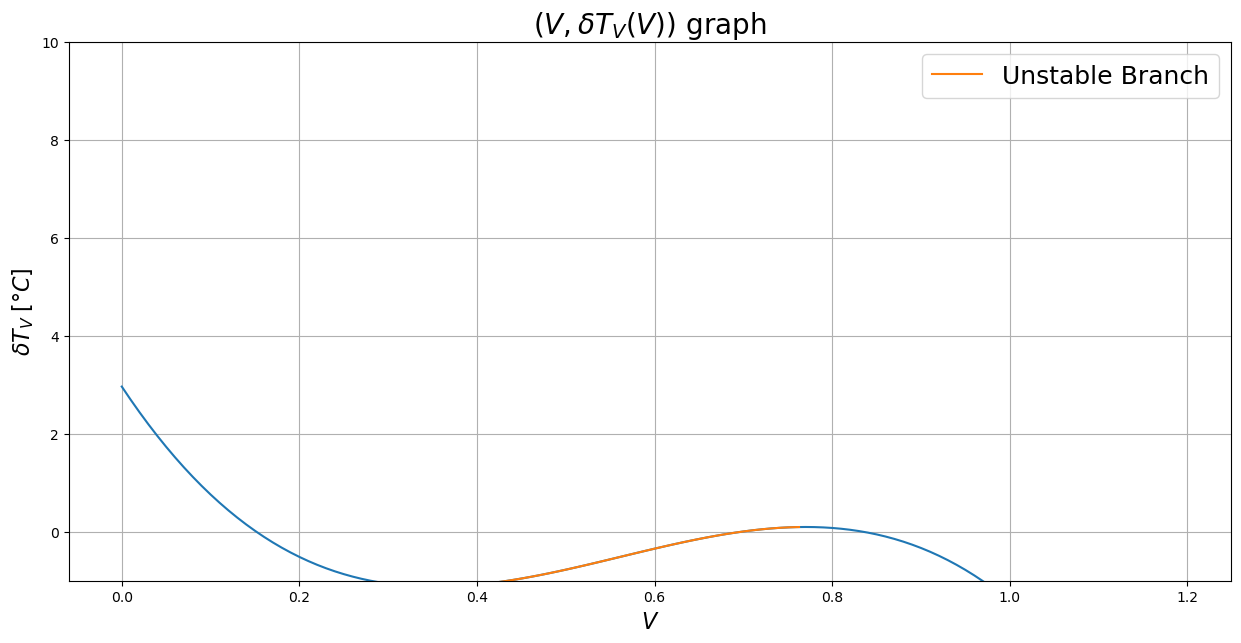

In [162]:
fig, ax = plt.subplots(1,1,figsize=(15,7))

plt.plot(v_range, Tv_fct_v)
plt.plot(unstable_v, Tv_fct_v_unstable, color = "tab:orange", label="Unstable Branch")
ax.set_xlabel(r"$V$", fontsize=16)
ax.set_ylabel(r"$\delta T_V\;[°C]$", fontsize=16)
ax.set_ybound([-1,10])
plt.title(r"$(V, \delta T_V(V))$ graph", fontsize = 20)
plt.legend(fontsize=18)
plt.grid()

plt.show()

Plot of the $(v, T_V(v))$ graph - Bifurcation diagram of $\delta T_V$

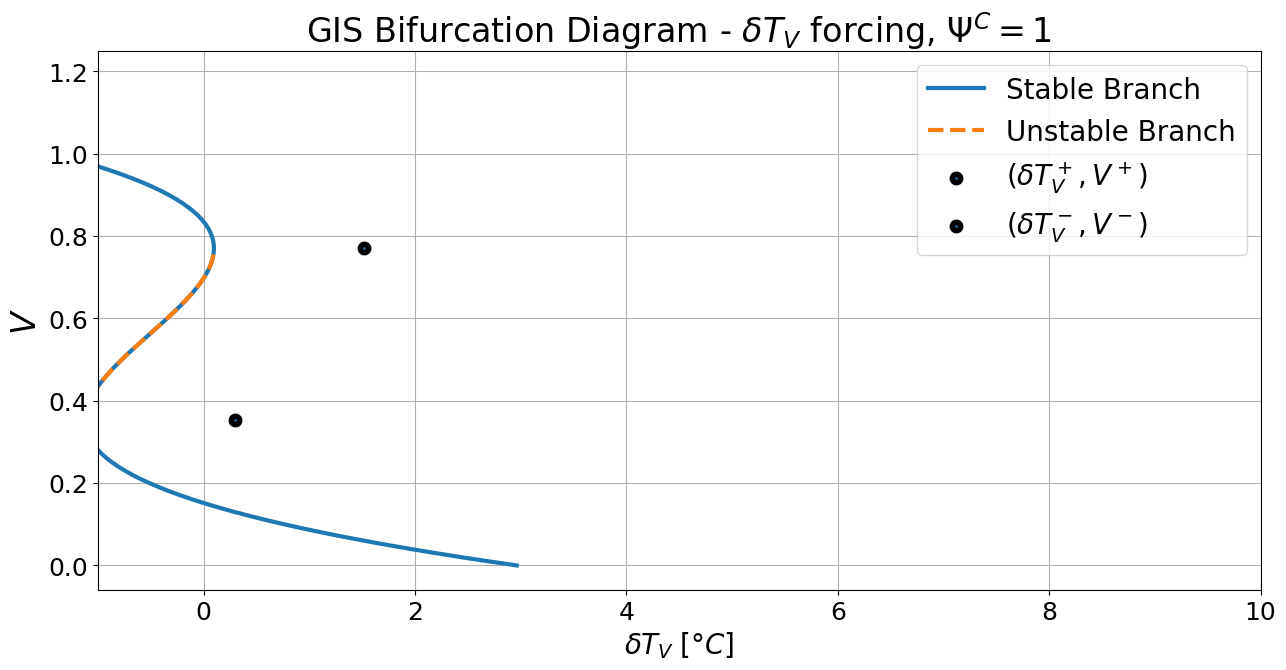

In [163]:
### Plotting ###

fig, ax = plt.subplots(1,1,figsize=(15,7))

## Plot of the bifurcation diagram ##
plt.plot(Tv_fct_v, v_range, label="Stable Branch", lw=3)
plt.plot(Tv_fct_v_unstable, unstable_v, color="tab:orange", label="Unstable Branch", lw=3, linestyle="dashed")

## Plot of the critical points ##
plt.scatter(GIS_crit_params[2],GIS_crit_params[0], marker='o', color="#1f77b4", linewidths=4, edgecolors="black", label=r"$(\delta T_V^+, V^+)$")
plt.scatter(GIS_crit_params[3],GIS_crit_params[1], marker='o', color="#1f77b4", linewidths=4, edgecolors="black", label=r"$(\delta T_V^-, V^-)$")

## Plot cosmetics ##
ax.set_xlabel(r"$\delta T_V\;[°C]$", fontsize=20)
ax.set_ylabel(r"$V$", fontsize=24)
ax.set_xbound([-1,10])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(r"GIS Bifurcation Diagram - $\delta T_V$ forcing, $\Psi^C = {} $".format(Psi_C), fontsize = 24)
plt.legend(fontsize=20)
plt.grid()

plt.show()

# Linux ThinkPad path fig.savefig(r"/home/amaury/Bureau/LPHYS2299 - Master's Thesis/Code/AMOC-GIS Tipping Module/Tipping Module Calibration - Param A/Figures/Bifurcation Diagram/GIS_T_BD_PsiC={}.png".format(Psi_C))
fig.savefig(r"C:\Users\AL000111\Documents\Mémoire\Code\LPHYS2299-Master-s-Thesis\AMOC-GIS Tipping Module\Tipping Module Calibration - Param A\Figures\Bifurcation Diagram\GIS_T_BD_PsiC={}.png".format(Psi_C))

Plot of the $(V, \Psi_V(V))$ graph

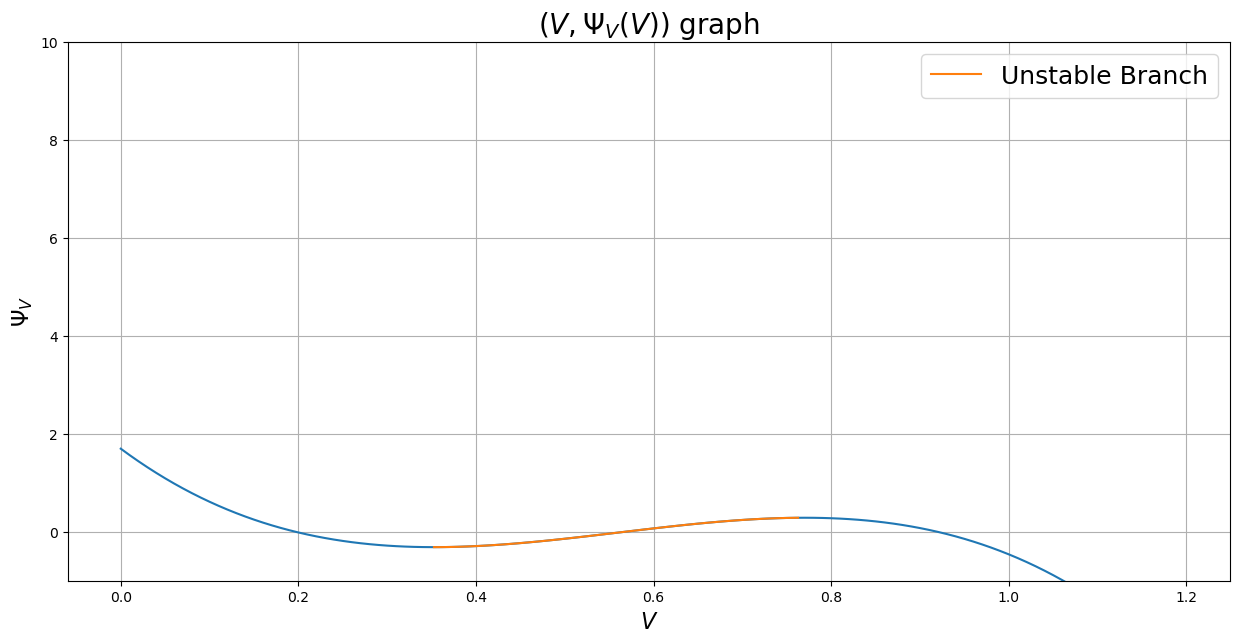

In [164]:
fig, ax = plt.subplots(1,1,figsize=(15,7))

plt.plot(v_range, Psi_fct_v)
plt.plot(unstable_v, Psi_fct_v_unstable, color = "tab:orange", label="Unstable Branch")
ax.set_xlabel(r"$V$", fontsize=16)
ax.set_ylabel(r"$\Psi_V$", fontsize=16)
ax.set_ybound([-1,10])
plt.title(r"$(V, \Psi_V(V))$ graph", fontsize = 20)
plt.legend(fontsize=18)
plt.grid()

plt.show()


Plot of the $(\Psi_V, V(\Psi_V))$ graph - Bifurcation diagram of $\Psi_V$

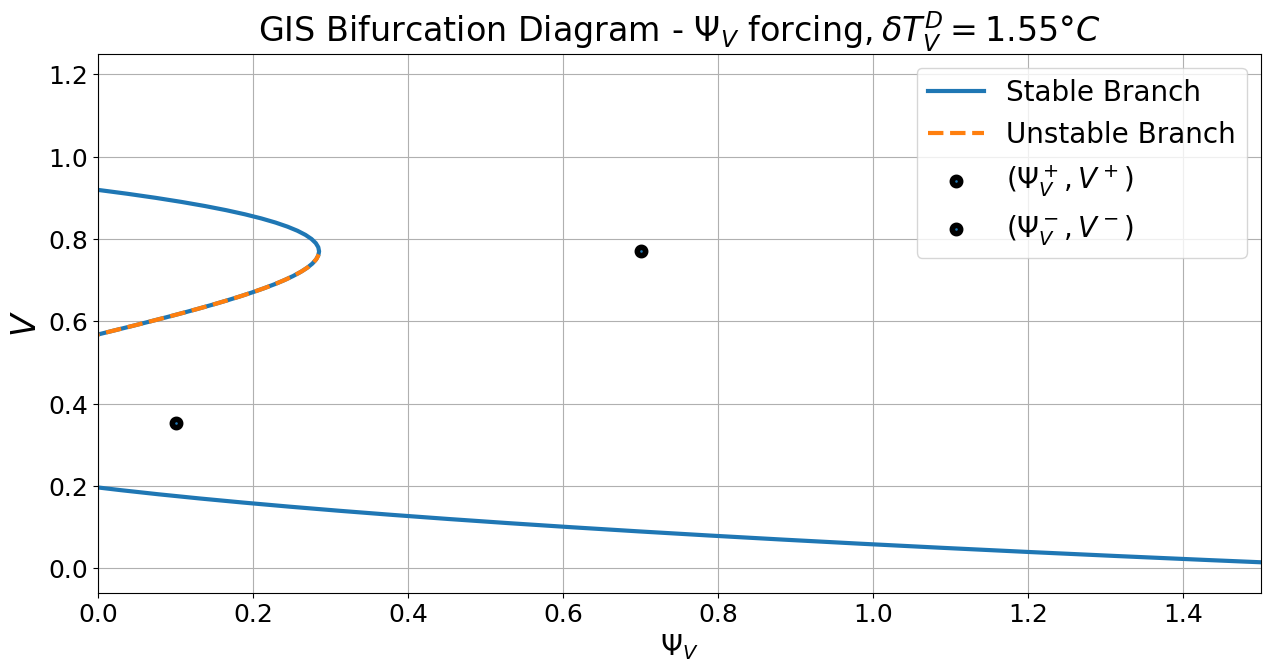

In [165]:
### Plotting ###

fig, ax = plt.subplots(1,1,figsize=(15,7))

## Plot of the bifurcation diagram ##
plt.plot(Psi_fct_v, v_range, label="Stable Branch", lw=3)
plt.plot(Psi_fct_v_unstable, unstable_v, color="tab:orange", label="Unstable Branch", lw=3, linestyle="dashed")

## Plot of the critical points ##
plt.scatter(GIS_crit_params[4],GIS_crit_params[0], marker='o', color="#1f77b4", linewidths=4, edgecolors="black", label=r"$(\Psi_V^+, V^+)$")
plt.scatter(GIS_crit_params[5],GIS_crit_params[1], marker='o', color="#1f77b4", linewidths=4, edgecolors="black", label=r"$(\Psi_V^-, V^-)$")

## Plot cosmetics ##
ax.set_xlabel(r"$\Psi_V$", fontsize=20)
ax.set_ylabel(r"$V$", fontsize=24)
ax.set_xbound([0,1.5])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(r"GIS Bifurcation Diagram - $\Psi_V$ forcing,"+r"$ \:\delta T_V^D = {}°C$".format(T_D), fontsize = 24)
plt.legend(fontsize=20)
plt.grid()

plt.show()

# Linux ThinkPad path fig.savefig(r"/home/amaury/Bureau/LPHYS2299 - Master's Thesis/Code/AMOC-GIS Tipping Module/Tipping Module Calibration - Param A/Figures/Bifurcation Diagram/GIS_Psi_BD_TD={}.png".format(T_D))
fig.savefig(r"C:\Users\AL000111\Documents\Mémoire\Code\LPHYS2299-Master-s-Thesis\AMOC-GIS Tipping Module\Tipping Module Calibration - Param A\Figures\Bifurcation Diagram\GIS_Psi_BD_TD={}.png".format(T_D))